In [1]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing

from split_dataset import SplitDataset
from pathlib import Path
import pandas as pd 
import flammkuchen as fl

from bouter import EmbeddedExperiment

from matplotlib import pyplot as plt

from skimage import io
import numpy as np 
from scipy import signal
import scipy.io 

from scipy.stats import zscore
from scipy.stats import sem

from scipy.interpolate import interp1d

import seaborn as sns
import json

from mpl_toolkits import mplot3d
%matplotlib widget

from skimage import measure

import networkx as nx
import matplotlib.gridspec as gridspec

import os
import numpy.ma as ma

import mypatterns as mpt

import statsmodels.api as sm

In [2]:
fish_id = "210317_f1" # 210317_f3  210320_f1 210317_f2 210316_f2  210317_f0
condition = 'stimuli' #rest #stimuli
#condition = 'rest' #rest



In [3]:
master_path = Path(r"\\FUNES\Shared\experiments\E0030_long_term_adaptation")
data_path = master_path / fish_id

master_path_out = Path(r"\\FUNES\Shared\Younes\long_term_adaptation\DynamicAnalysis")
#results_path = master_path_out  / fish_id / condition


master_path_morphed = Path(r"\\FUNES\Shared\experiments\E0030_long_term_adaptation\markovetal_supp\wholebrain_adaptation\files from RP")
traces_path = master_path_morphed / "traces"


rois_path = Path(r"\\FUNES\Shared\experiments\E0030_long_term_adaptation\markovetal_supp\wholebrain_adaptation\barcodes_for_LP\ROI_centroids")
                           

In [4]:
trace_all = scipy.io.loadmat(next(traces_path.glob(fish_id +'*')))
ROIs_all = scipy.io.loadmat(next(rois_path.glob(fish_id +'*')))

In [5]:
#isExist = os.path.exists(results_path)
#print(isExist)

#if not isExist:
#    os.makedirs(results_path)

In [6]:
current_exp = EmbeddedExperiment(list(data_path.glob("*metadata.json"))[0])

In [7]:
with open(next(data_path.glob("*metadata.json")), "r") as f:
    metadata = json.load(f)
    
zf = metadata["imaging"]["microscope_config"]["lightsheet"]["scanning"]["z"]["frequency"]
    
protocol_params = metadata["stimulus"]["protocol"]["E0030_long_term_adaptation"]["v09_lightsheet"]
protocol_params["lag"]



'0.225'

In [8]:
# load data from file called ___stimulus_log.hdf5:
# or stim_log_df = current_exp.stimulus_log
stim_log_df = fl.load(next(data_path.glob("*stimulus_log.hdf5")), "/data")

# load data from file called ___stimulus_log.hdf5:
# or beh_log_df = current_exp.beh_log_df
beh_log_df = fl.load(next(data_path.glob("*behavior_log.hdf5")), "/data")

In [9]:
dt=0.005
rest_dur=7.5
trial_dur=15
full_trial_dur=trial_dur+2*rest_dur
calib_notr=10
pre_notr=10
main_notr=50
post_notr=50
notr=calib_notr+pre_notr+main_notr+post_notr
exp_dur=notr*full_trial_dur


gr_starts=  np.arange(rest_dur,2*rest_dur+(notr-1)*full_trial_dur,full_trial_dur)
gr_ends=gr_starts+trial_dur
t_pre_start=full_trial_dur*calib_notr
t_main_start=full_trial_dur*(calib_notr+pre_notr)
t_post_start=full_trial_dur*(calib_notr+pre_notr+main_notr)

time_be = np.arange(dt,exp_dur+dt,dt)

In [10]:
#import scipy.io
#Behav = scipy.io.loadmat('AdaptationFish_Behavior.mat')

bad_points = np.diff(stim_log_df.t)==0
t_stim = np.asarray(stim_log_df.t)
t_stim = t_stim[np.argwhere(~bad_points)] 

base_grspeed_general =  np.asarray(stim_log_df.general_cl1D_base_vel)
base_grspeed_general = base_grspeed_general[np.argwhere(~bad_points)] 
stim_general = 1-np.isnan(base_grspeed_general)
base_grspeed_general[np.isnan(base_grspeed_general)] = 0

base_grspeed_gain =  np.asarray(stim_log_df.gain_lag_cl1D_base_vel)
base_grspeed_gain = base_grspeed_gain[np.argwhere(~bad_points)] 
stim_gain = 1-np.isnan(base_grspeed_gain)
base_grspeed_gain[np.isnan(base_grspeed_gain)] = 0


base_grspeed_calibraiting =  np.asarray(stim_log_df.calibrating_cl1D_base_vel)
base_grspeed_calibraiting = base_grspeed_calibraiting[np.argwhere(~bad_points)] 
stim_calibratiting = 1-np.isnan(base_grspeed_calibraiting)
base_grspeed_calibraiting[np.isnan(base_grspeed_calibraiting)] = 0


base_grspeed = - base_grspeed_general - base_grspeed_gain - base_grspeed_calibraiting


grspeed_general =  np.asarray(stim_log_df.general_cl1D_vel)
grspeed_general = grspeed_general[np.argwhere(~bad_points)] 
grspeed_general[np.isnan(grspeed_general)] = 0

grspeed_gain =  np.asarray(stim_log_df.gain_lag_cl1D_vel)
grspeed_gain = grspeed_gain[np.argwhere(~bad_points)] 
grspeed_gain[np.isnan(grspeed_gain)] = 0


grspeed_calibraiting =  np.asarray(stim_log_df.calibrating_cl1D_vel)
grspeed_calibraiting = grspeed_calibraiting[np.argwhere(~bad_points)] 
grspeed_calibraiting[np.isnan(grspeed_calibraiting)] = 0

grspeed = - grspeed_general - grspeed_gain - grspeed_calibraiting 

swim_general =  np.asarray(stim_log_df.general_cl1D_fish_swimming)
swim_general = swim_general[np.argwhere(~bad_points)] 
swim_general[pd.isna(swim_general)] = 0

swim_calibrating =  np.asarray(stim_log_df.calibrating_cl1D_fish_swimming)
swim_calibrating = swim_calibrating[np.argwhere(~bad_points)] 
swim_calibrating[pd.isna(swim_calibrating)] = 0

swim_gain =  np.asarray(stim_log_df.gain_lag_cl1D_fish_swimming)
swim_gain = swim_gain[np.argwhere(~bad_points)] 
swim_gain[pd.isna(swim_gain)] = 0

swim = swim_general + swim_gain + swim_calibrating
swim = np.concatenate(swim).astype(None)


bad_points = np.diff(beh_log_df.t)==0
t_be = np.asarray(beh_log_df.t)
t_be = t_be[np.argwhere(~bad_points)] 

tail =  np.asarray(beh_log_df.tail_sum)
tail =  tail[np.argwhere(~bad_points)] 


set_interp_tail = interp1d(np.squeeze(t_be), np.squeeze(tail), kind='linear',fill_value="extrapolate")
tail = set_interp_tail(time_be)

set_interp_swim = interp1d(np.squeeze(t_stim), np.squeeze(swim), kind='linear',fill_value="extrapolate")
swim = set_interp_swim(time_be)>=0.5

set_interp_grspeed = interp1d(np.squeeze(t_stim), np.squeeze(grspeed), kind= 'linear',fill_value="extrapolate")
grspeed = set_interp_grspeed(time_be)

set_interp_grmov = interp1d(np.squeeze(t_stim), np.squeeze(base_grspeed), kind= 'linear',fill_value="extrapolate")
grmov = set_interp_grmov(time_be)>.5

set_interp_genral = interp1d(np.squeeze(t_stim), np.squeeze(stim_general), kind= 'linear',fill_value="extrapolate")
stim_general =  set_interp_genral(time_be)>.5
stim_general = stim_general[0:-1:100]

set_interp_gain = interp1d(np.squeeze(t_stim), np.squeeze(stim_gain), kind= 'linear',fill_value="extrapolate")
stim_gain =  set_interp_gain(time_be)>.5
stim_gain = stim_gain[0:-1:100]

set_interp_calibratiting  = interp1d(np.squeeze(t_stim), np.squeeze(stim_calibratiting), kind= 'linear',fill_value="extrapolate")
stim_calibratiting =  set_interp_calibratiting(time_be)>.5
stim_calibratiting = stim_calibratiting[0:-1:100]


tail=tail-np.nanmean(tail[~swim])
tail=tail/np.nanstd(tail[swim])
tail[np.isnan(tail)]=0

#vigor= np.empty(len(tail))
#vigor[:] = np.nan


reg = np.zeros(int(exp_dur*zf))

if condition == "stimuli":
    reg_starts = (zf*gr_starts).astype(int)
    reg_ends = (zf*gr_ends).astype(int)
    reg_dur = trial_dur*zf
elif condition == "rest":
    reg_starts =  (zf*gr_ends[:-1]).astype(int)
    reg_ends = (zf*gr_starts[1:]).astype(int)
    reg_dur = 2*rest_dur*zf

reg_notr = len(reg_starts)


for t in range(reg_notr):
    reg[reg_starts[t]:reg_ends[t]:1] = 1
    
    


In [11]:
boutfeat = current_exp.get_bout_properties()

nob =len(boutfeat)
boutfeat.trial = np.empty(nob)
boutfeat.trial[:] = np.nan
boutfeat.t_end = boutfeat.t_start +  boutfeat.duration
boutfeat.next_interbout_duration = np.empty(nob)
boutfeat.next_interbout_duration[:] = np.nan



trial_latency = np.empty(notr)
trial_latency[:] = np.nan

trial_number_of_bouts = np.empty(notr)
trial_number_of_bouts[:] = 0

for g in range(notr):
    bouts_in_this_trial= np.argwhere(((boutfeat.t_start>gr_starts[g]) & (boutfeat.t_end<gr_ends[g])).to_numpy())
    if bouts_in_this_trial.size:
        trial_number_of_bouts[g]=len(bouts_in_this_trial)
        trial_latency[g]=boutfeat.t_start[bouts_in_this_trial[0]] - gr_starts[g]
        for b in bouts_in_this_trial:
            boutfeat.trial[b]=g
            if b<bouts_in_this_trial[-1]:
                boutfeat.next_interbout_duration[b]=boutfeat.t_start[b*1]-boutfeat.t_end[b]    


C:\Users\Younes\anaconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  after removing the cwd from sys.path.
C:\Users\Younes\anaconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
C:\Users\Younes\anaconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys


In [12]:
# load data from file called __traces.h5:
TC = trace_all['traces']
# Remove some NaNs at the start
#TC =  TC[3747:,]

In [13]:
nantest = np.sum(TC,axis = -1)
TC = np.squeeze(TC[np.argwhere(~np.isnan(nantest)),:])

In [14]:
fc_baseline=1/300  # Hz, 5 min period
TC=mpt.clean(TC, sampling_frq = zf, highpass = fc_baseline)

In [15]:
# preparing normalized features (to mimic cosine distances)

X, selected_frames = mpt.select_frames(TC, method = 'REG', time_mask=reg)


In [16]:
centers, cluster_labels, nb_clusters = mpt.get_patterns(X)

In [17]:
XYZ = ROIs_all['ROI_centroids']

In [18]:
xx =  np.squeeze(XYZ[np.argwhere(~np.isnan(nantest)),0])
yy =  np.squeeze(XYZ[np.argwhere(~np.isnan(nantest)),1])
zz = np.squeeze(XYZ[np.argwhere(~np.isnan(nantest)),2])

In [19]:
n_clusters = nb_clusters
cluster_labels_trial = cluster_labels.reshape((int(reg_notr), int(reg_dur)))
reg_kk = np.zeros([n_clusters,np.size(X,axis=0)])
reg_kk_trial =  np.zeros([n_clusters, int(reg_notr), int(reg_dur)])
reg_kk_blocks =  np.zeros([n_clusters, int(reg_notr), int(reg_dur)])
reg_kk_blocks_end_pos  =  np.zeros([n_clusters, int(reg_notr), int(reg_dur)])
reg_kk_blocks_duration  =  np.empty([n_clusters, int(reg_notr), int(reg_dur)])
reg_kk_blocks_duration[:] =  np.NaN
reg_kk_blocks_positions  =  np.empty([n_clusters, int(reg_notr), int(reg_dur)])
reg_kk_blocks_positions[:]  =  np.NaN


meanposition_occ_per_trial = np.empty([n_clusters, int(reg_notr)])
meanposition_occ_per_trial[:] = np.NaN

occ_trial_first = np.empty([n_clusters, int(reg_notr)])
occ_trial_first[:] = np.NaN


for k in range(n_clusters):
    reg_kk[k,:] = (cluster_labels == k)  
    reg_kk_trial[k,:,:] = (cluster_labels_trial == k)
    
    
occ_per_trial = np.sum(reg_kk_trial,2)    


for k in range(n_clusters):
    for ntr in range(reg_notr):
        cur_tri = np.argwhere(reg_kk_trial[k,ntr,:])
        if (occ_per_trial[k,ntr] > 0):
            occ_trial_first[k,ntr] = cur_tri[0]
            meanposition_occ_per_trial[k,ntr] = np.mean(cur_tri)
            all_labels = measure.label(reg_kk_trial[k,ntr,:],background=0)
            for some_label in range(1, max(all_labels)+1):
                inds_label =  np.argwhere(all_labels == some_label)
                reg_kk_blocks[k,ntr,inds_label[0].astype(int)] = 1
                reg_kk_blocks_positions[k,ntr,inds_label[0].astype(int)] = inds_label[0]
                reg_kk_blocks_duration[k,ntr,inds_label[0].astype(int)] =  inds_label[-1]  - inds_label[0]
                if inds_label[-1] + 1 < reg_dur:
                    reg_kk_blocks_end_pos[k,ntr, inds_label[-1] + 1] =1


                
reg_kk_trial_blocks = np.sum(reg_kk_blocks, -1)
reg_kk_trial_blocks_duration = np.nanmean(reg_kk_blocks_duration, -1)
reg_kk_trial_blocks_positions = np.nanmean(reg_kk_blocks_positions, -1)



C:\Users\Younes\anaconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
C:\Users\Younes\anaconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: Mean of empty slice


In [20]:
calib_notr_reg = calib_notr -1  if condition == "rest" else  calib_notr

pre_notr_reg=calib_notr_reg + pre_notr
main_notr_reg=pre_notr_reg + main_notr
post_notr=main_notr_reg + post_notr

occ_per_trial_calibratiting = np.squeeze(occ_per_trial[:, :calib_notr_reg])
occ_trial_first_calibratiting = np.squeeze(occ_trial_first[:,:calib_notr_reg])

occ_per_trial_pre_general = np.squeeze(occ_per_trial[:, calib_notr_reg:pre_notr_reg:1])
occ_trial_first_pre_general = np.squeeze(occ_trial_first[:,calib_notr_reg:pre_notr_reg:1]) 


occ_per_trial_gain = np.squeeze(occ_per_trial[:,pre_notr_reg:main_notr_reg:1])
occ_trial_first_gain = np.squeeze(occ_trial_first[:, pre_notr_reg:main_notr_reg:1])

occ_per_trial_general = np.squeeze(occ_per_trial[:, main_notr_reg:post_notr:1])
occ_trial_first_general = np.squeeze(occ_trial_first[:, main_notr_reg:post_notr:1]) 



In [21]:
up_inds = np.argsort(np.nanmean(reg_kk_trial_blocks_positions, -1))

occ_per_trial= occ_per_trial[up_inds,:]
occ_per_trial_pre_general = occ_per_trial_pre_general[up_inds,:]
occ_per_trial_gain = occ_per_trial_gain[up_inds,:]
occ_per_trial_calibratiting = occ_per_trial_calibratiting[up_inds,:]
occ_per_trial_general = occ_per_trial_general[up_inds,:]


occ_trial_first = occ_trial_first[up_inds,:]/zf
occ_per_trial_pre_general = occ_per_trial_pre_general[up_inds,:]/zf
occ_trial_first_general = occ_trial_first_general[up_inds,:]/zf
occ_trial_first_gain = occ_trial_first_gain[up_inds,:]/zf
occ_trial_first_calibratiting = occ_trial_first_calibratiting[up_inds,:]/zf


reg_kk_trial_blocks = reg_kk_trial_blocks[up_inds,:]
reg_kk_trial_blocks_duration = reg_kk_trial_blocks_duration[up_inds,:]/zf
reg_kk_trial_blocks_positions = reg_kk_trial_blocks_positions[up_inds,:]/zf



reg_kk_trial_blocks_calibratiting = reg_kk_trial_blocks[:,:calib_notr_reg]
reg_kk_trial_blocks_duration_calibratiting = reg_kk_trial_blocks_duration[:,:calib_notr_reg]
reg_kk_trial_blocks_positions_calibratiting = reg_kk_trial_blocks_positions[:,:calib_notr_reg]

reg_kk_trial_blocks_pre_general = reg_kk_trial_blocks[:,calib_notr_reg:pre_notr_reg:1]
reg_kk_trial_blocks_duration_pre_general = reg_kk_trial_blocks_duration[:,calib_notr_reg:pre_notr_reg:1]
reg_kk_trial_blocks_positions_pre_general = reg_kk_trial_blocks_positions[:,calib_notr_reg:pre_notr_reg:1]

reg_kk_trial_blocks_gain = reg_kk_trial_blocks[:,pre_notr_reg:main_notr_reg:1]
reg_kk_trial_blocks_duration_gain = reg_kk_trial_blocks_duration[:, pre_notr_reg:main_notr_reg:1]
reg_kk_trial_blocks_positions_gain = reg_kk_trial_blocks_positions[:, pre_notr_reg:main_notr_reg:1]

reg_kk_trial_blocks_general = reg_kk_trial_blocks[:,main_notr_reg:post_notr:1]
reg_kk_trial_blocks_duration_general= reg_kk_trial_blocks_duration[:,main_notr_reg:post_notr:1]
reg_kk_trial_blocks_positions_general = reg_kk_trial_blocks_positions[:,main_notr_reg:post_notr:1]


centers = centers[up_inds,:]

lat_lim = 1 if condition == "rest" else  0

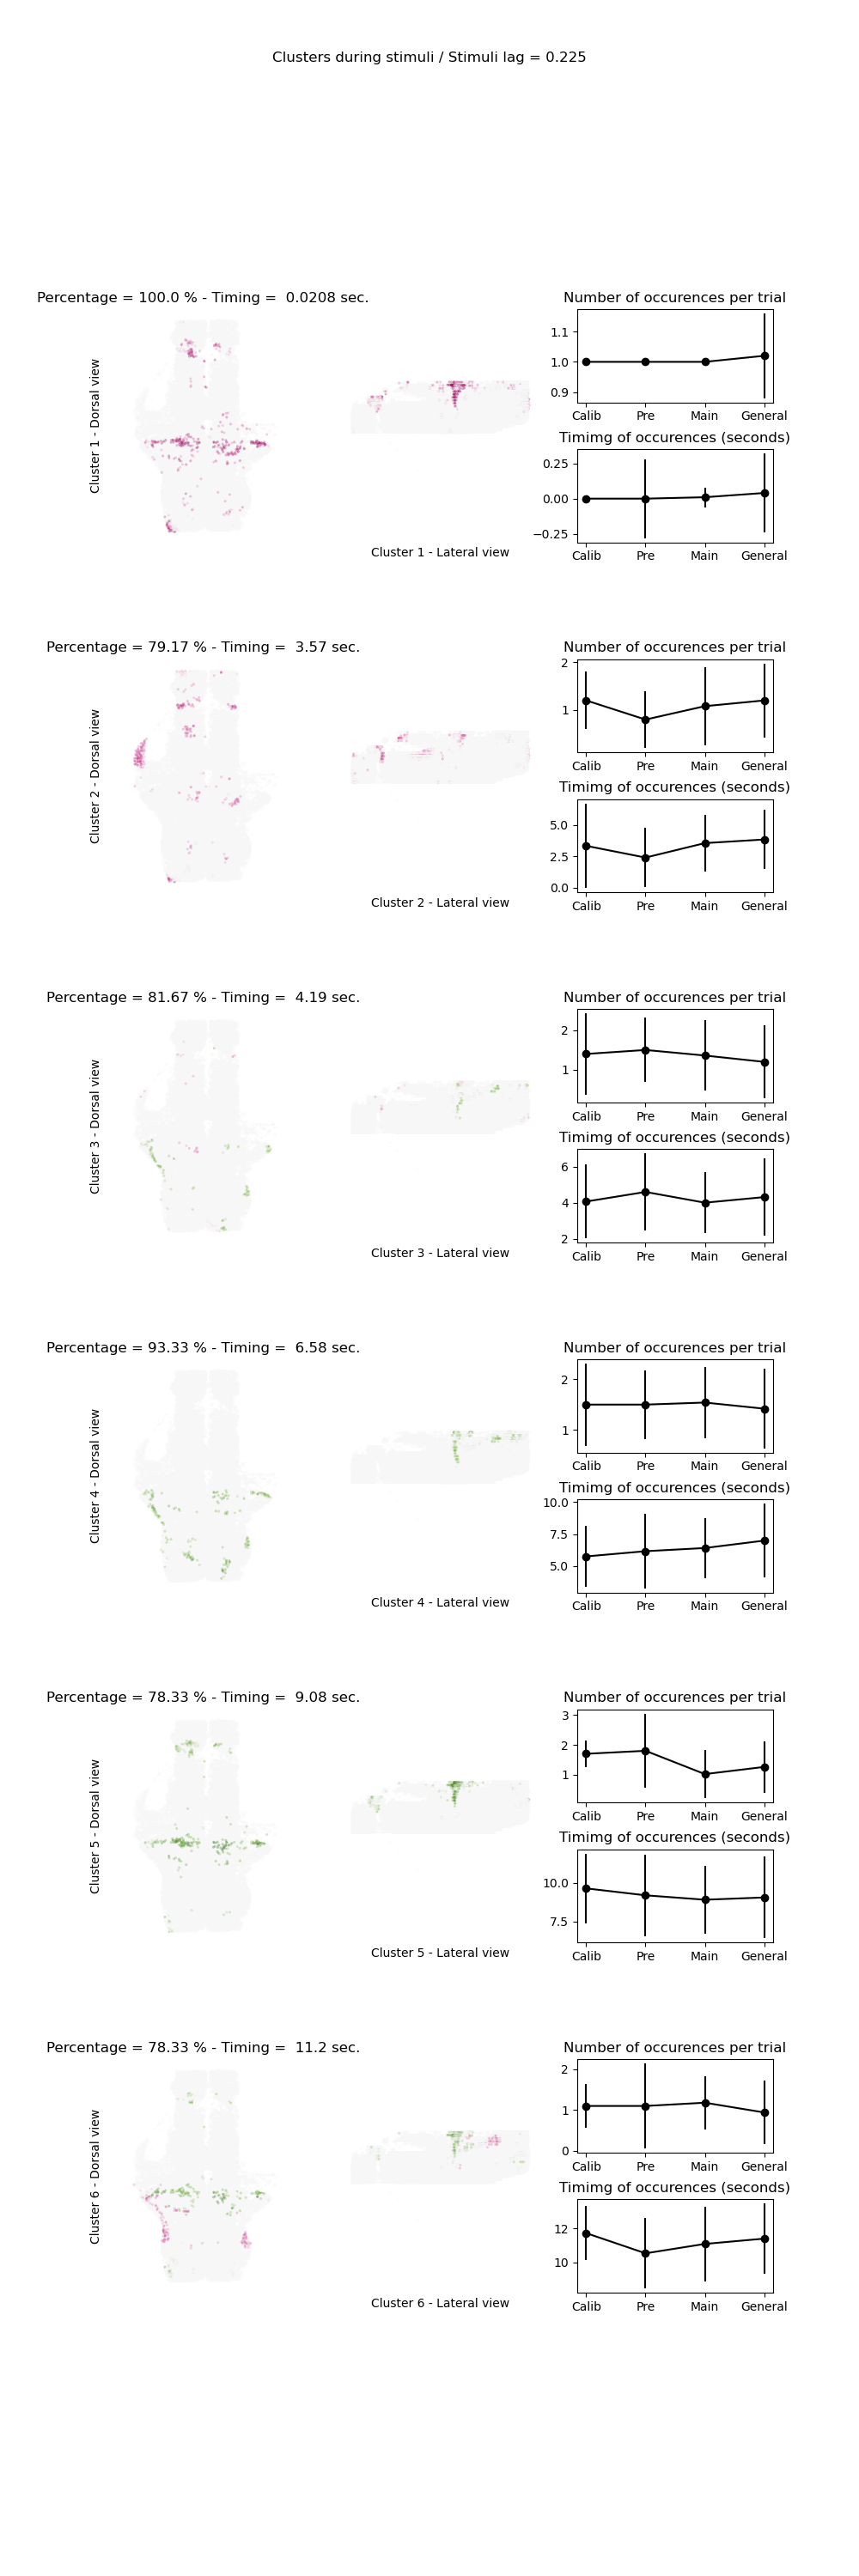

In [22]:
labels = ['Calib', 'Pre', 'Main', 'General']
width = 0.35  

plt.close('all') 
plt.clf 

#plt.style.use('dark_background')
plt.style.use('default')
my_cmap = plt.get_cmap('PiYG_r')


fig = plt.figure(figsize=(10,n_clusters*5))

#fig = plt.figure()

gs0 = gridspec.GridSpec(n_clusters, 3, figure=fig,hspace = .5)

for i in range(n_clusters):
    datap_occ =  [reg_kk_trial_blocks_calibratiting[i,:] , reg_kk_trial_blocks_pre_general[i,:] ,reg_kk_trial_blocks_gain[i,:] ,  reg_kk_trial_blocks_general[i,:]]
    datap_first = [reg_kk_trial_blocks_positions_calibratiting[i,:], reg_kk_trial_blocks_positions_pre_general[i,:] , reg_kk_trial_blocks_positions_gain[i,:] ,reg_kk_trial_blocks_positions_general[i,:]]
    
    #datap_occ =  [occ_per_trial_calibratiting[i,:] , occ_per_trial_pre_general[i,:] , occ_per_trial_gain[i,:] ,  occ_per_trial_general[i,:]]
    #datap_first = [occ_trial_first_calibratiting[i,:], occ_trial_first_pre_general[i,:] , occ_trial_first_gain[i,:] , occ_trial_first_general[i,:]]
    
    Xplot = np.squeeze(centers[i,:])
    Xplot -= np.mean(Xplot)
    Xplot /= np.std(Xplot)
    Xplot[np.abs(Xplot) < 3 ] = 0
    
    ax = fig.add_subplot(gs0[i, 0])
    ax.scatter(yy, xx, lw=0, s=20, alpha=0.3,  vmin=-5, vmax=5,
                    c = Xplot,
                    cmap = my_cmap,
                    marker ='.')
    plt.gca().invert_yaxis()
    ax.set_title("Percentage = {:1.4} % - Timing =  {:1.3} sec. ".format(np.count_nonzero(reg_kk_trial_blocks[i,:])*100 / np.size(reg_kk_trial_blocks, axis =1), np.nanmean(reg_kk_trial_blocks_positions[i,:])))
    ax.set_ylabel("Cluster {} - Dorsal view".format(i+1))
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_frame_on(False)
    ax.axis("equal")
    ax = fig.add_subplot(gs0[i, 1])
    plt.scatter(xx, zz, lw=0, s=20, alpha=0.3,  vmin=-5, vmax=5,
                    c = Xplot,
                    cmap = my_cmap,
                    marker ='.')
    plt.gca().invert_yaxis()
    ax.set_xlabel("Cluster {} - Lateral view".format(i+1))
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_frame_on(False)
    ax.axis("equal")
    gs01 = gs0[i,2].subgridspec(2, 1,hspace = .5)
    
    datap_occ_mean = [np.nanmean(reg_kk_trial_blocks_calibratiting[i,:]) , np.nanmean(reg_kk_trial_blocks_pre_general[i,:]) , np.nanmean(reg_kk_trial_blocks_gain[i,:]) , np.nanmean(reg_kk_trial_blocks_general[i,:])]
    datap_first_mean = [np.nanmean(reg_kk_trial_blocks_positions_calibratiting[i,:]) , np.nanmean(reg_kk_trial_blocks_positions_pre_general[i,:]) , np.nanmean(reg_kk_trial_blocks_positions_gain[i,:]) , np.nanmean(reg_kk_trial_blocks_positions_general[i,:])]

    datap_occ_std = [np.nanstd(reg_kk_trial_blocks_calibratiting[i,:]) , np.nanstd(reg_kk_trial_blocks_pre_general[i,:]) , np.nanstd(reg_kk_trial_blocks_gain[i,:]) , np.nanstd(reg_kk_trial_blocks_general[i,:])]
    datap_first_std = [np.nanstd(reg_kk_trial_blocks_positions_calibratiting[i,:]) , np.nanstd(reg_kk_trial_blocks_positions_general[i,:]) , np.nanstd(reg_kk_trial_blocks_positions_gain[i,:]) , np.nanstd(reg_kk_trial_blocks_positions_general[i,:])]

    ax = fig.add_subplot(gs01[0,:])
    ax.errorbar(labels,datap_occ_mean, yerr=datap_occ_std, marker='o', linestyle="-",color = "black")
    ax.set_title('Number of occurences per trial')    
    ax = fig.add_subplot(gs01[1,:])
    ax.errorbar(labels,datap_first_mean, yerr=datap_first_std, marker='o', linestyle="-",color = "black")
    ax.set_title('Timimg of occurences (seconds)')

    
fig.suptitle("Clusters during {} / Stimuli lag = {}".format(condition,protocol_params["lag"]))    
    
plt.show()    
#plt.savefig('{}/Clusters.png'.format(results_path), format='png')
#plt.savefig('{}/Clusters.pdf'.format(results_path), format='pdf')


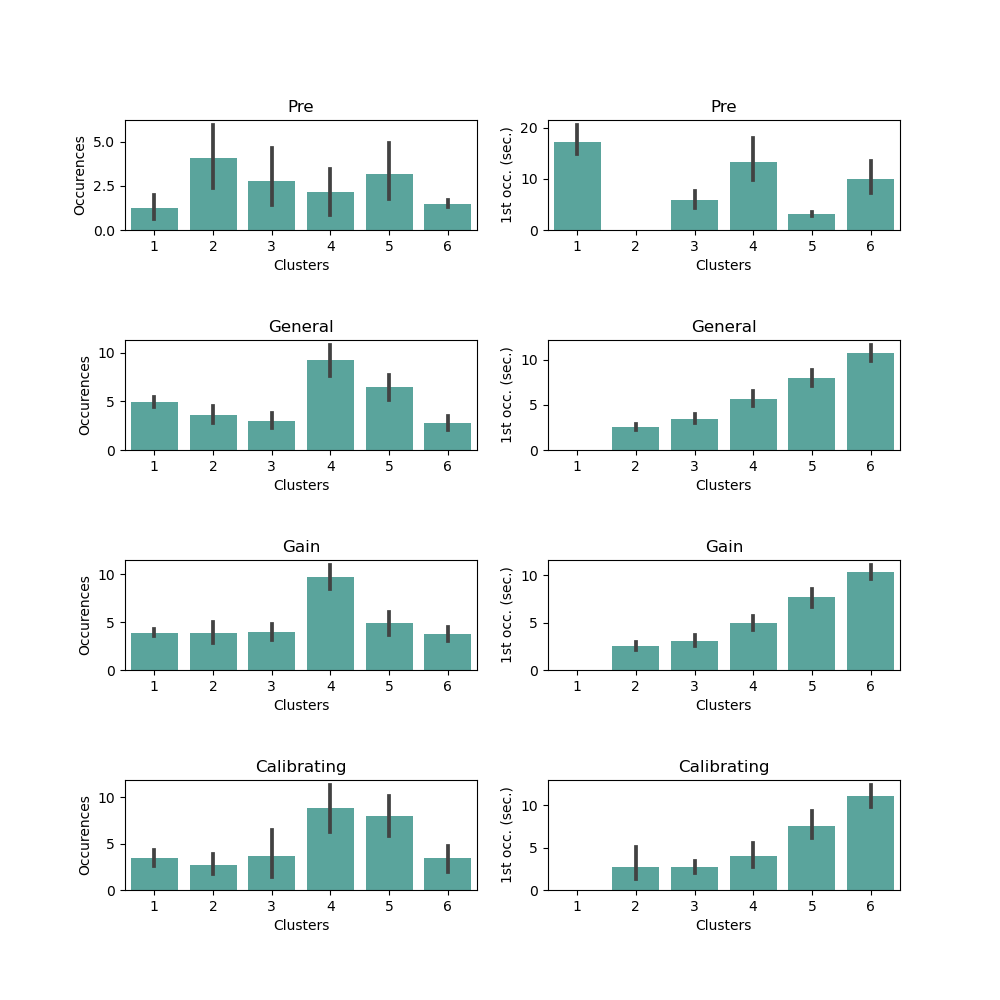

In [23]:
plt.close('all') 
plt.clf 

fig = plt.figure(figsize=(10,10))

#fig = plt.figure()

gs0 = gridspec.GridSpec(4, 2, figure=fig, hspace = 1)
sns.despine()



ax = fig.add_subplot(gs0[0, 0])
df_plot= {}
for i in np.arange(1,n_clusters+1):
    df_plot[str(i)] = occ_per_trial_pre_general[i-1,:]

df_plot=pd.DataFrame(df_plot)

sns.barplot(data =  df_plot ,  color="#4db1a6")
ax.set_title('Pre')
ax.set_ylabel('Occurences')
ax.set_xlabel('Clusters')

ax = fig.add_subplot(gs0[0, 1])
df_plot= {}
for i in np.arange(1,n_clusters+1):
    df_plot[str(i)] = occ_trial_first_pre_general[i-1,:]

df_plot=pd.DataFrame(df_plot)

sns.barplot(data =  df_plot ,  color="#4db1a6")
ax.set_title('Pre')
ax.set_ylabel('1st occ. (sec.)')
ax.set_xlabel('Clusters')

ax = fig.add_subplot(gs0[1, 0])
df_plot= {}
for i in np.arange(1,n_clusters+1):
    df_plot[str(i)] = occ_per_trial_general[i-1,:]

df_plot=pd.DataFrame(df_plot)

sns.barplot(data =  df_plot ,  color="#4db1a6")
ax.set_title('General')
ax.set_ylabel('Occurences')
ax.set_xlabel('Clusters')

ax = fig.add_subplot(gs0[1, 1])
df_plot= {}
for i in np.arange(1,n_clusters+1):
    df_plot[str(i)] = occ_trial_first_general[i-1,:]

df_plot=pd.DataFrame(df_plot)

sns.barplot(data =  df_plot ,  color="#4db1a6")
ax.set_title('General')
ax.set_ylabel('1st occ. (sec.)')
ax.set_xlabel('Clusters')

ax = fig.add_subplot(gs0[2, 0])
df_plot= {}
for i in np.arange(1,n_clusters+1):
    df_plot[str(i)] = occ_per_trial_gain[i-1,:]

df_plot=pd.DataFrame(df_plot)

sns.barplot(data =  df_plot ,  color="#4db1a6")
ax.set_title('Gain')
ax.set_ylabel('Occurences')
ax.set_xlabel('Clusters')

ax = fig.add_subplot(gs0[2, 1])
df_plot= {}
for i in np.arange(1,n_clusters+1):
    df_plot[str(i)] = occ_trial_first_gain[i-1,:]

df_plot=pd.DataFrame(df_plot)

sns.barplot(data =  df_plot ,  color="#4db1a6")
ax.set_title('Gain')
ax.set_ylabel('1st occ. (sec.)')
ax.set_xlabel('Clusters')

ax = fig.add_subplot(gs0[3, 0])
df_plot= {}
for i in np.arange(1,n_clusters+1):
    df_plot[str(i)] = occ_per_trial_calibratiting[i-1,:]

df_plot=pd.DataFrame(df_plot)

sns.barplot(data =  df_plot ,  color="#4db1a6")
ax.set_title('Calibrating')
ax.set_ylabel('Occurences')
ax.set_xlabel('Clusters')

ax = fig.add_subplot(gs0[3, 1])
df_plot= {}
for i in np.arange(1,n_clusters+1):
    df_plot[str(i)] = occ_trial_first_calibratiting[i-1,:]

df_plot=pd.DataFrame(df_plot)

sns.barplot(data =  df_plot ,  color="#4db1a6")
ax.set_title('Calibrating')
ax.set_ylabel('1st occ. (sec.)')
ax.set_xlabel('Clusters')

    
plt.show()    
#plt.savefig('{}/OccurenceStat.png'.format(results_path), format='png')
#plt.savefig('{}/OccurenceStat.pdf'.format(results_path), format='pdf')




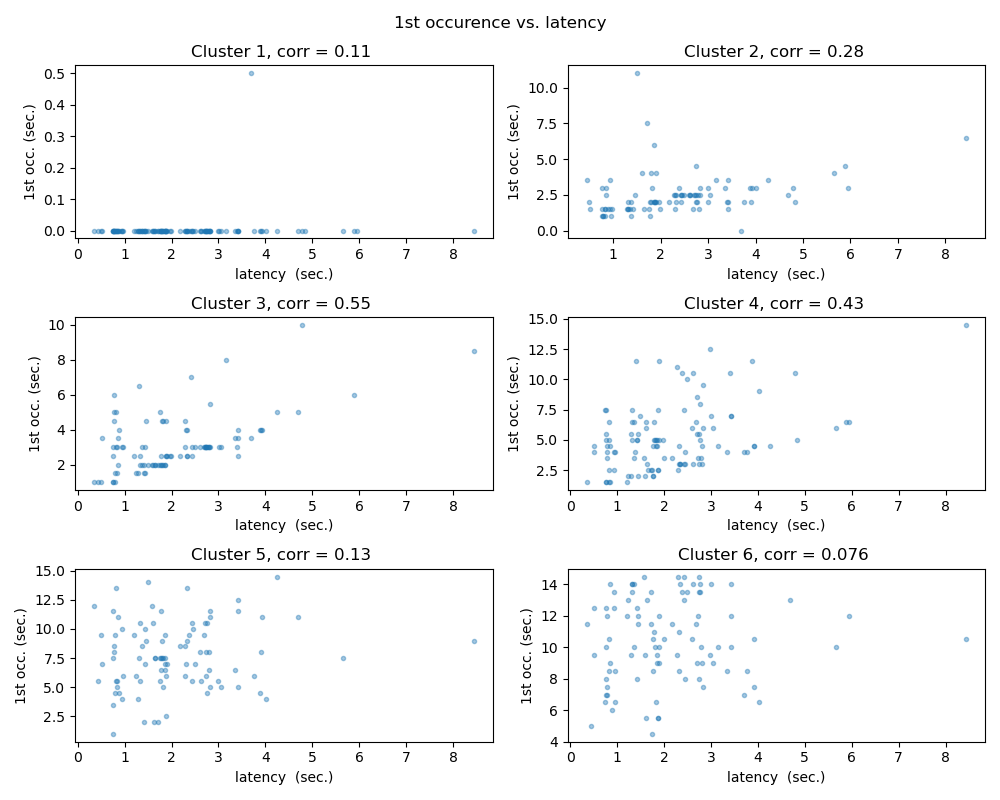

In [24]:
plt.close('all') 
plt.clf 


fig = plt.figure(figsize=(10,8))

#fig = plt.figure()


b = 2  # number of columns
a = round(n_clusters/b)  # number of rows
c = 1  # initialize plot counter

for j in range(n_clusters):
    ax = plt.subplot(a, b, c)
    indsc = np.argwhere(~np.isnan(occ_trial_first[j,lat_lim:]))
    sc_occ_trial_first = occ_trial_first[j,indsc]
    sc_trial_latency = trial_latency[indsc]
    #sc_trial_number_of_bouts = trial_number_of_bouts[indsc]
    
    #crc = np.corrcoef(np.concatenate(sc_trial_latency).astype(None),np.concatenate(sc_occ_trial_first).astype(None))
    crc = ma.corrcoef(ma.masked_invalid(np.concatenate(sc_trial_latency).astype(None)), ma.masked_invalid(np.concatenate(sc_occ_trial_first).astype(None)))


    
    indsc = np.argsort(np.concatenate(sc_trial_latency).astype(None))
    ax.scatter(sc_trial_latency[indsc],sc_occ_trial_first[indsc],alpha = 0.4,marker ='.')
    ax.set_ylabel('1st occ. (sec.)')
    ax.set_xlabel('latency  (sec.)')
    ax.set_title("Cluster {}, corr = {:1.2} ".format(j+1,crc[0,1]))
    c=c+1

fig.suptitle('1st occurence vs. latency') 
fig.tight_layout()
    
# show plot
plt.show()    

#plt.savefig('{}/firstocc_vs_latency.png'.format(results_path), format='png')
#plt.savefig('{}/firstocc_vs_latency.pdf'.format(results_path), format='pdf')



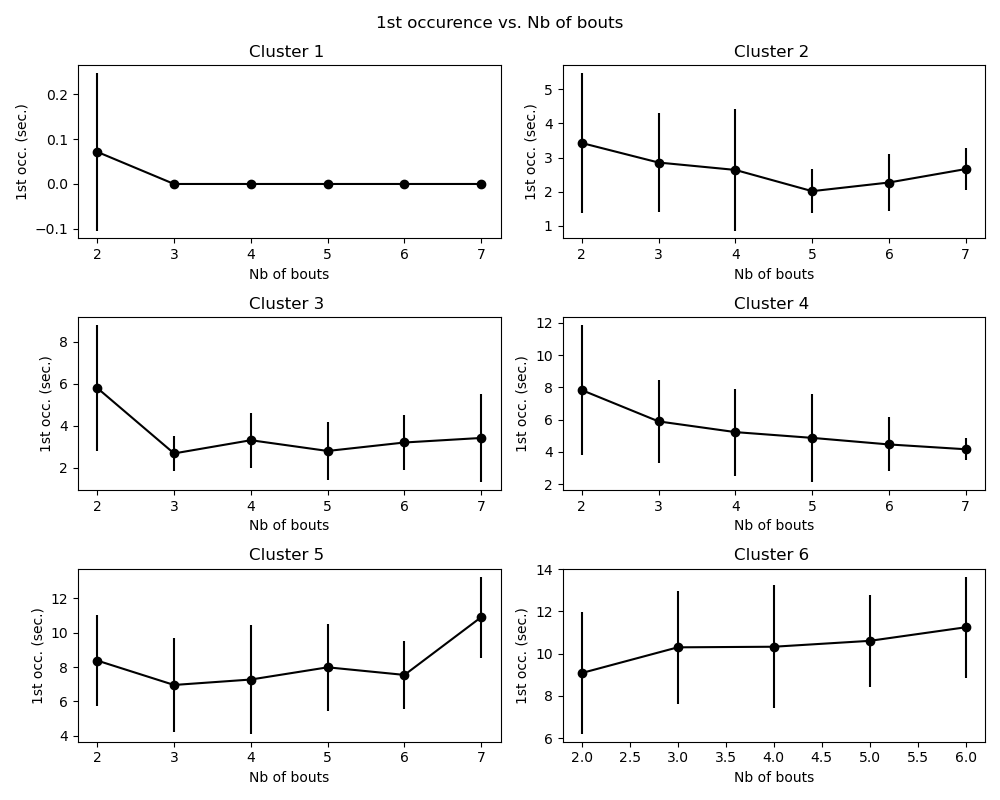

In [25]:
plt.close('all') 
plt.clf 


fig = plt.figure(figsize=(10,8))

#fig = plt.figure()


b = 2  # number of columns
a = round(n_clusters/b)  # number of rows
c = 1  # initialize plot counter

for j in range(n_clusters):
    ax = plt.subplot(a, b, c)
    indsc = np.argwhere(~np.isnan(occ_trial_first[j,lat_lim:]))
    sc_occ_trial_first = occ_trial_first[j,indsc]
    sc_trial_number_of_bouts = trial_number_of_bouts[indsc]
    #sc_trial_number_of_bouts = trial_number_of_bouts[indsc]
    
    
    mean_bouts_occ_plot = np.empty(int(max(sc_trial_number_of_bouts)))
    mean_bouts_occ_plot[:] = np.NaN
    std_bouts_occ_plot = np.empty(int(max(sc_trial_number_of_bouts)))
    std_bouts_occ_plot[:] = np.NaN 

    
    for bt in range(int(max(sc_trial_number_of_bouts))):
        if sum(sc_trial_number_of_bouts == bt):
            mean_bouts_occ_plot[bt] = np.nanmean(sc_occ_trial_first[sc_trial_number_of_bouts == bt])
            std_bouts_occ_plot[bt] = np.nanstd(sc_occ_trial_first[sc_trial_number_of_bouts == bt]) 
        
    labels = np.arange(max(sc_trial_number_of_bouts))
    
    nanlab_test = ~np.isnan(mean_bouts_occ_plot)
    mean_bouts_occ_plot = mean_bouts_occ_plot[nanlab_test]
    std_bouts_occ_plot = std_bouts_occ_plot[nanlab_test]
    labels = labels[nanlab_test]


    
    ax.errorbar(labels,mean_bouts_occ_plot, yerr=std_bouts_occ_plot, marker='o', linestyle="-",color = "black")
    ax.set_ylabel('1st occ. (sec.)')
    ax.set_xlabel('Nb of bouts')
    ax.set_title("Cluster {} ".format(j+1))
    c=c+1

fig.suptitle('1st occurence vs. Nb of bouts') 
fig.tight_layout()
    
# show plot
plt.show()
#plt.savefig('{}/firstocc_vs_bouts.png'.format(results_path), format='png')
#plt.savefig('{}/firstocc_vs_bouts.pdf'.format(results_path), format='pdf')



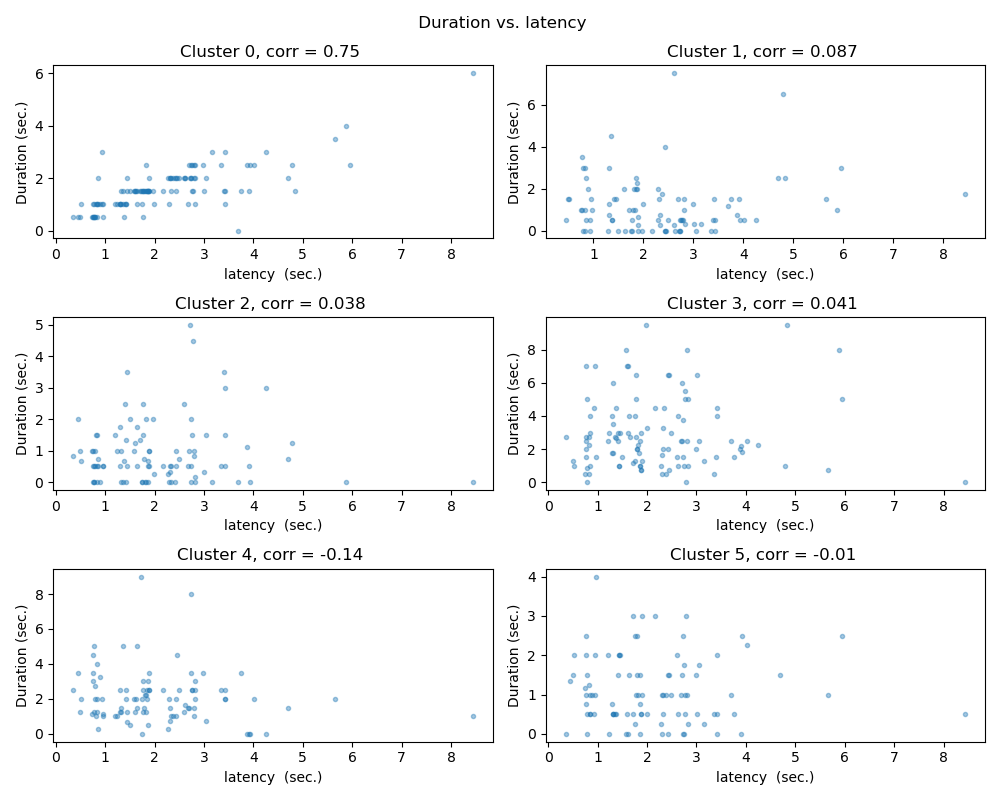

In [26]:
plt.close('all') 
plt.clf 


fig = plt.figure(figsize=(10,8))

#fig = plt.figure()


b = 2  # number of columns
a = round(n_clusters/b)  # number of rows
c = 1  # initialize plot counter

for j in range(n_clusters):
    ax = plt.subplot(a, b, c)
    
    indsc = np.argwhere(~np.isnan(reg_kk_trial_blocks_duration[j,lat_lim:]))
    sc_occ_per_trial = reg_kk_trial_blocks_duration[j,indsc]
    sc_trial_latency = trial_latency[indsc]
    #sc_trial_number_of_bouts = trial_number_of_bouts[indsc]
    
    #crc = np.corrcoef(np.concatenate(sc_trial_latency).astype(None),np.concatenate(sc_occ_per_trial).astype(None))
    crc = ma.corrcoef(ma.masked_invalid(np.concatenate(sc_trial_latency).astype(None)), ma.masked_invalid(np.concatenate(sc_occ_per_trial).astype(None)))

    indsc = np.argsort(np.concatenate(sc_trial_latency).astype(None))
    ax.scatter(sc_trial_latency[indsc],sc_occ_per_trial[indsc],alpha = 0.4,marker ='.')
    ax.set_ylabel('Duration (sec.)')
    ax.set_xlabel('latency  (sec.)')
    ax.set_title("Cluster {}, corr = {:0.2} ".format(j,crc[0,1]))
    c=c+1

fig.suptitle(' Duration vs. latency') 
fig.tight_layout()

    
# show plot
plt.show()    

#plt.savefig('{}/Duration_vs_latency.png'.format(results_path), format='png')
#plt.savefig('{}/Duration_vs_latency.pdf'.format(results_path), format='pdf')



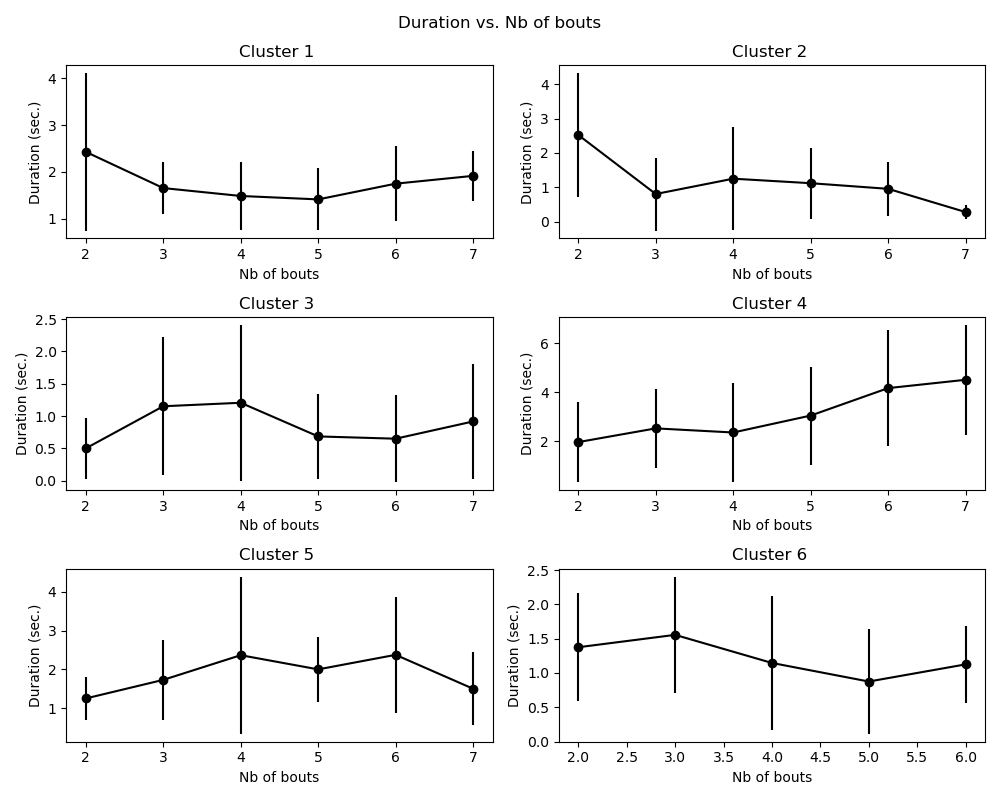

In [27]:
plt.close('all') 
plt.clf 


fig = plt.figure(figsize=(10,8))

#fig = plt.figure()


b = 2  # number of columns
a = round(n_clusters/b)  # number of rows
c = 1  # initialize plot counter

for j in range(n_clusters):
    ax = plt.subplot(a, b, c)
   
    indsc = np.argwhere(~np.isnan(reg_kk_trial_blocks_duration[j,lat_lim:]))
    sc_trial_blocks_duration = reg_kk_trial_blocks_duration[j,indsc]
    sc_trial_number_of_bouts = trial_number_of_bouts[indsc]
    
    
    mean_bouts_dur_plot = np.empty(int(max(sc_trial_number_of_bouts)))
    mean_bouts_dur_plot[:] = np.NaN
    std_bouts_dur_plot = np.empty(int(max(sc_trial_number_of_bouts)))
    std_bouts_dur_plot[:] = np.NaN 

    
    for bt in range(int(max(sc_trial_number_of_bouts))):
        if sum(sc_trial_number_of_bouts == bt):
            mean_bouts_dur_plot[bt] = np.nanmean(sc_trial_blocks_duration[sc_trial_number_of_bouts == bt])
            std_bouts_dur_plot[bt] = np.nanstd(sc_trial_blocks_duration[sc_trial_number_of_bouts == bt]) 
        
    labels = np.arange(max(sc_trial_number_of_bouts))
    
    nanlab_test = ~np.isnan(mean_bouts_dur_plot)
    mean_bouts_dur_plot = mean_bouts_dur_plot[nanlab_test]
    std_bouts_dur_plot = std_bouts_dur_plot[nanlab_test]
    labels = labels[nanlab_test]


    
    ax.errorbar(labels,mean_bouts_dur_plot, yerr=std_bouts_dur_plot, marker='o', linestyle="-",color = "black")
    ax.set_ylabel('Duration (sec.)')
    ax.set_xlabel('Nb of bouts')
    ax.set_title("Cluster {} ".format(j+1))
    c=c+1

fig.suptitle('Duration vs. Nb of bouts') 
fig.tight_layout()

    
# show plot

plt.show()    

#plt.savefig('{}/Duration_vs_bouts.png'.format(results_path), format='png')
#plt.savefig('{}/Duration_vs_bouts.pdf'.format(results_path), format='pdf')



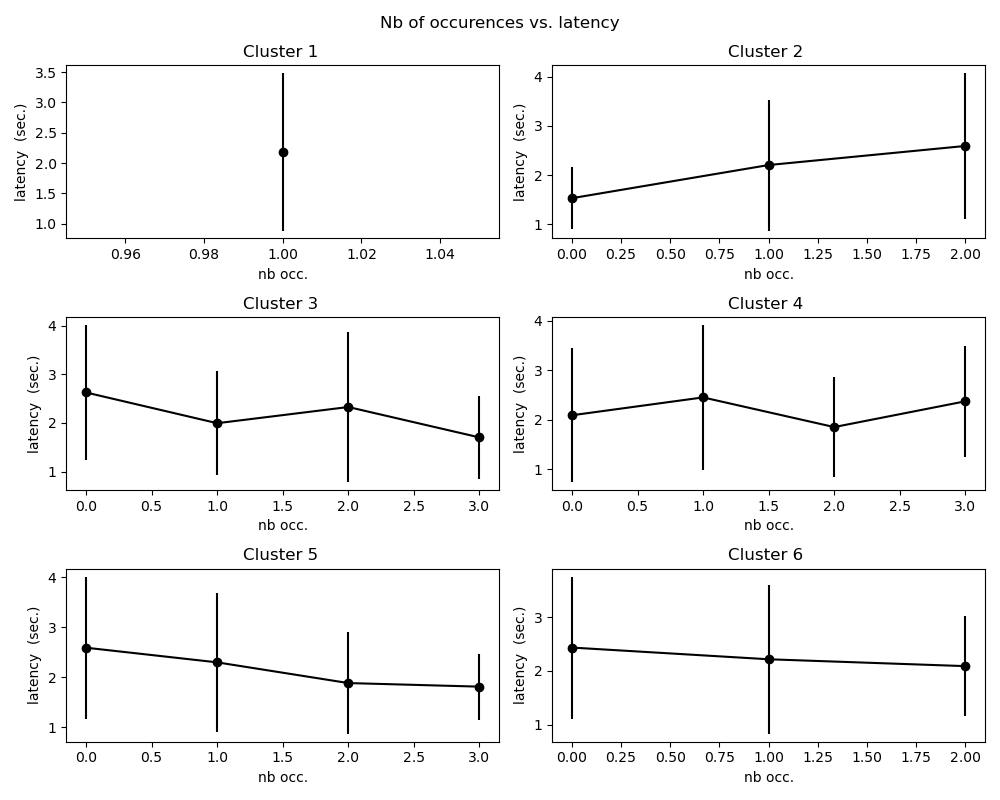

In [28]:
plt.close('all') 
plt.clf 


fig = plt.figure(figsize=(10,8))

#fig = plt.figure()


b = 2  # number of columns
a = round(n_clusters/b)  # number of rows
c = 1  # initialize plot counter

for j in range(n_clusters):
    ax = plt.subplot(a, b, c)
    
    indsc = np.argwhere(~np.isnan(reg_kk_trial_blocks[j,lat_lim:]))
    sc_occ_per_trial = reg_kk_trial_blocks[j,indsc]
    sc_trial_latency = trial_latency[indsc]
    #sc_trial_number_of_bouts = trial_number_of_bouts[indsc]
    
    
    
    mean_occ_latency_plot = np.empty(int(max(sc_occ_per_trial)))
    mean_occ_latency_plot[:] = np.NaN
    std_occ_latency_plot = np.empty(int(max(sc_occ_per_trial)))
    std_occ_latency_plot[:] = np.NaN 
    
    for bt in range(int(max(sc_occ_per_trial))):
        if sum(sc_occ_per_trial == bt):
            mean_occ_latency_plot[bt] = np.nanmean(sc_trial_latency[sc_occ_per_trial == bt])
            std_occ_latency_plot[bt] = np.nanstd(sc_trial_latency[sc_occ_per_trial == bt])
            
    labels = np.arange(max(sc_occ_per_trial))
    
    nanlab_test = ~np.isnan(mean_occ_latency_plot)
    mean_occ_latency_plot = mean_occ_latency_plot[nanlab_test]
    std_occ_latency_plot = std_occ_latency_plot[nanlab_test]
    labels = labels[nanlab_test]       
    

    ax.errorbar(labels,mean_occ_latency_plot, yerr=std_occ_latency_plot, marker='o', linestyle="-",color = "black")
    ax.set_xlabel('nb occ.')
    ax.set_ylabel('latency  (sec.)')
    ax.set_title("Cluster {} ".format(j+1))
    c=c+1

fig.suptitle('Nb of occurences vs. latency') 
fig.tight_layout()

    
# show plot

plt.show()    

#plt.savefig('{}/Occ_vs_latency.png'.format(results_path), format='png')
#plt.savefig('{}/Occ_vs_latency.pdf'.format(results_path), format='pdf')

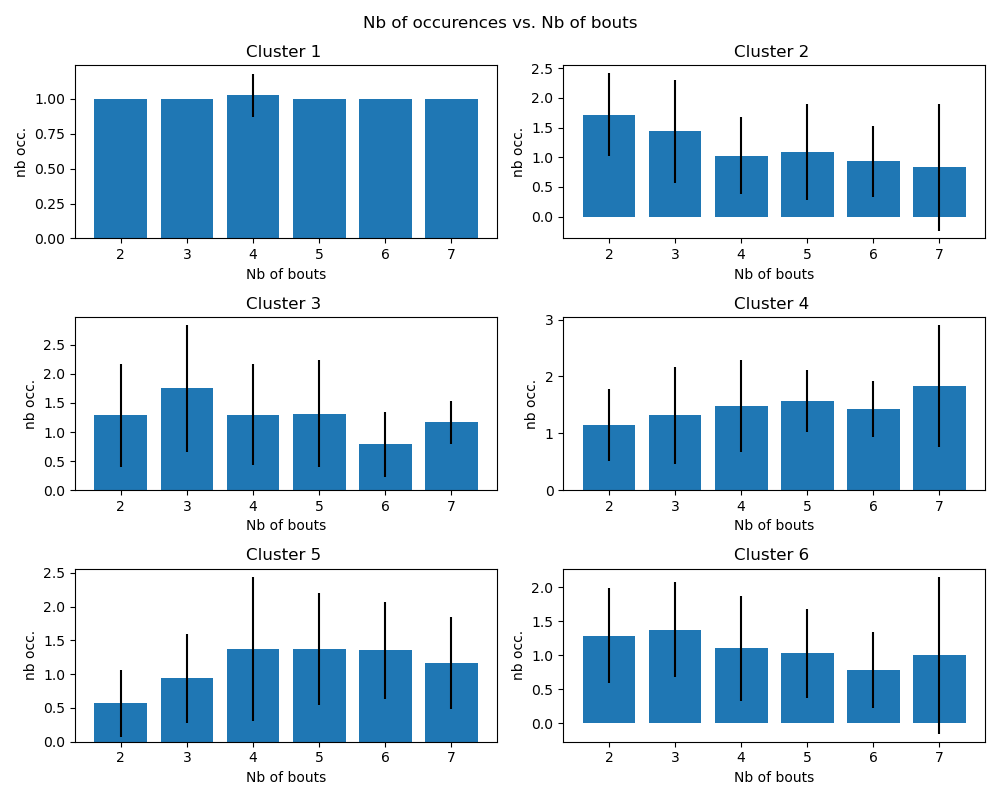

In [29]:
plt.close('all') 
plt.clf 


fig = plt.figure(figsize=(10,8))

#fig = plt.figure()


b = 2  # number of columns
a = round(n_clusters/b)  # number of rows
c = 1  # initialize plot counter

for j in range(n_clusters):
    ax = plt.subplot(a, b, c)
    
    indsc = np.argwhere(~np.isnan(reg_kk_trial_blocks[j,lat_lim:]))
    sc_occ_per_trial = reg_kk_trial_blocks[j,indsc]
    sc_trial_number_of_bouts = trial_number_of_bouts[indsc]
    #sc_trial_number_of_bouts = trial_number_of_bouts[indsc]
    

    mean_occ_bouts_plot = np.empty(int(max(sc_trial_number_of_bouts)))
    mean_occ_bouts_plot[:] = np.NaN
    std_occ_bouts_plot = np.empty(int(max(sc_trial_number_of_bouts)))
    std_occ_bouts_plot[:] = np.NaN 
    
    
    for bt in range(int(max(sc_trial_number_of_bouts))):
        if sum(sc_trial_number_of_bouts == bt):
            mean_occ_bouts_plot[bt] = np.nanmean(sc_occ_per_trial[sc_trial_number_of_bouts == bt])
            std_occ_bouts_plot[bt] = np.nanstd(sc_occ_per_trial[sc_trial_number_of_bouts == bt])
            
            
    labels = np.arange(max(sc_trial_number_of_bouts))
    
    nanlab_test = ~np.isnan(mean_occ_bouts_plot)
    mean_occ_bouts_plot = mean_occ_bouts_plot[nanlab_test]
    std_occ_bouts_plot = std_occ_bouts_plot[nanlab_test]
    labels = labels[nanlab_test]       
    

    ax.bar(labels,mean_occ_bouts_plot, yerr=std_occ_bouts_plot, )        
    ax.set_ylabel('nb occ.')
    ax.set_xlabel('Nb of bouts')
    ax.set_title("Cluster {} ".format(j+1))
    c=c+1

fig.suptitle('Nb of occurences vs. Nb of bouts') 
fig.tight_layout()

    
# show plot

plt.show()    

#plt.savefig('{}/occurences_vs_bouts.png'.format(results_path), format='png')
#plt.savefig('{}/occurences_vs_bouts.pdf'.format(results_path), format='pdf')

In [30]:
COUPLINGS = np.zeros([n_clusters,n_clusters])

for i in range(n_clusters):
    k1 = up_inds[i]
    cp = cluster_labels[np.argwhere(np.reshape(reg_kk_blocks_end_pos[k1,:],int(reg_notr*reg_dur)) == 1) ]
    for j in range(n_clusters):
        k2 = up_inds[j]
        COUPLINGS[i,j] = np.sum(cp == k2)/len(cp)
                

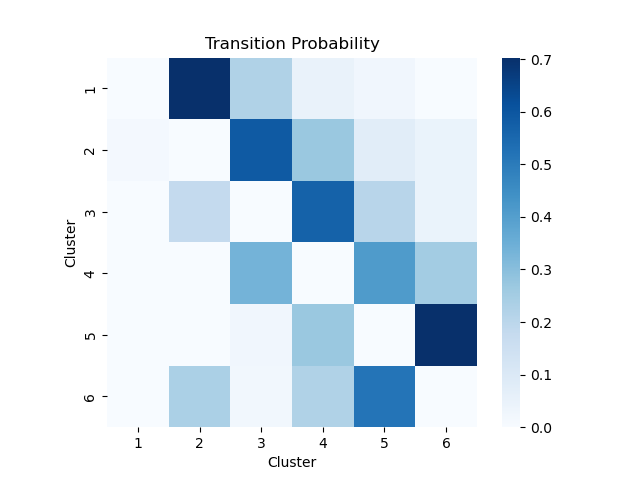

In [31]:
plt.close('all') 
plt.clf 

my_cmap2 = plt.get_cmap('Blues')

ax = sns.heatmap(
    COUPLINGS, 
    cmap=my_cmap2,
    square=True
)

ax.set_xticklabels(np.arange(1, n_clusters+1))
ax.set_yticklabels(np.arange(1, n_clusters+1))

plt.xlabel("Cluster") 
plt.ylabel("Cluster") 
plt.title('Transition Probability') 

plt.show()    


#plt.savefig('{}/TransitionProbMtx.png'.format(results_path), format='png')
#plt.savefig('{}/TransitionProbMtx.pdf'.format(results_path), format='pdf')



C:\Users\Younes\anaconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


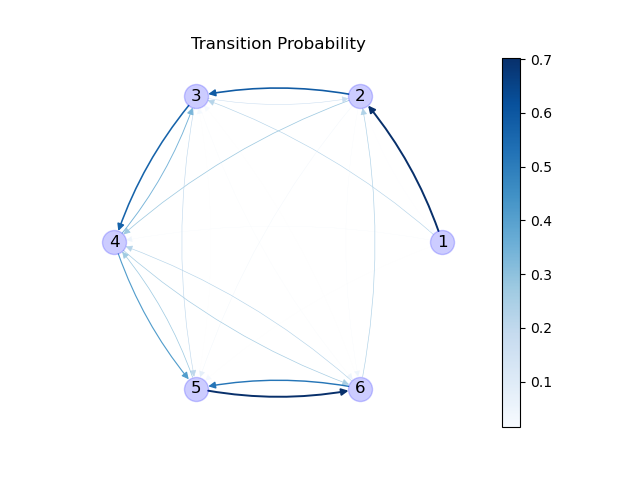

In [32]:
G = nx.DiGraph(COUPLINGS)
pos = nx.circular_layout(G)
#pos = nx.random_layout(G)

Glabels = {}    
for node in G.nodes():
        #set the node name as the key and the label as its value 
        Glabels[node] = str(node+1)
        
edges = nx.draw_networkx_edges(
    G, pos, edge_cmap=my_cmap2, connectionstyle="arc3,rad=0.1" ,
    edge_color=[G[u][v]['weight'] for u, v in G.edges], width = [G[u][v]['weight'] for u, v in G.edges],arrows=False)

plt.close('all') 
plt.clf 

mcl = nx.draw_networkx_edges(
    G, pos, edge_cmap=my_cmap2, connectionstyle="arc3,rad=0.1" ,
    edge_color=[G[u][v]['weight'] for u, v in G.edges], width = [2*G[u][v]['weight'] for u, v in G.edges])

nx.draw_networkx_nodes(G, pos,node_color = 'b', node_size = 300, alpha = .2, )
nx.draw_networkx_labels(G, pos, Glabels)

plt.colorbar(edges)
plt.axis('off')
plt.title('Transition Probability') 

plt.show()    


#plt.savefig('{}/TransitionProb.png'.format(results_path), format='png')
#plt.savefig('{}/TransitionProb.pdf'.format(results_path), format='pdf')

In [33]:
fbmin = 0
fbmax = 300
hbmin = 450
hbmax = 600
hbmax_z = 400

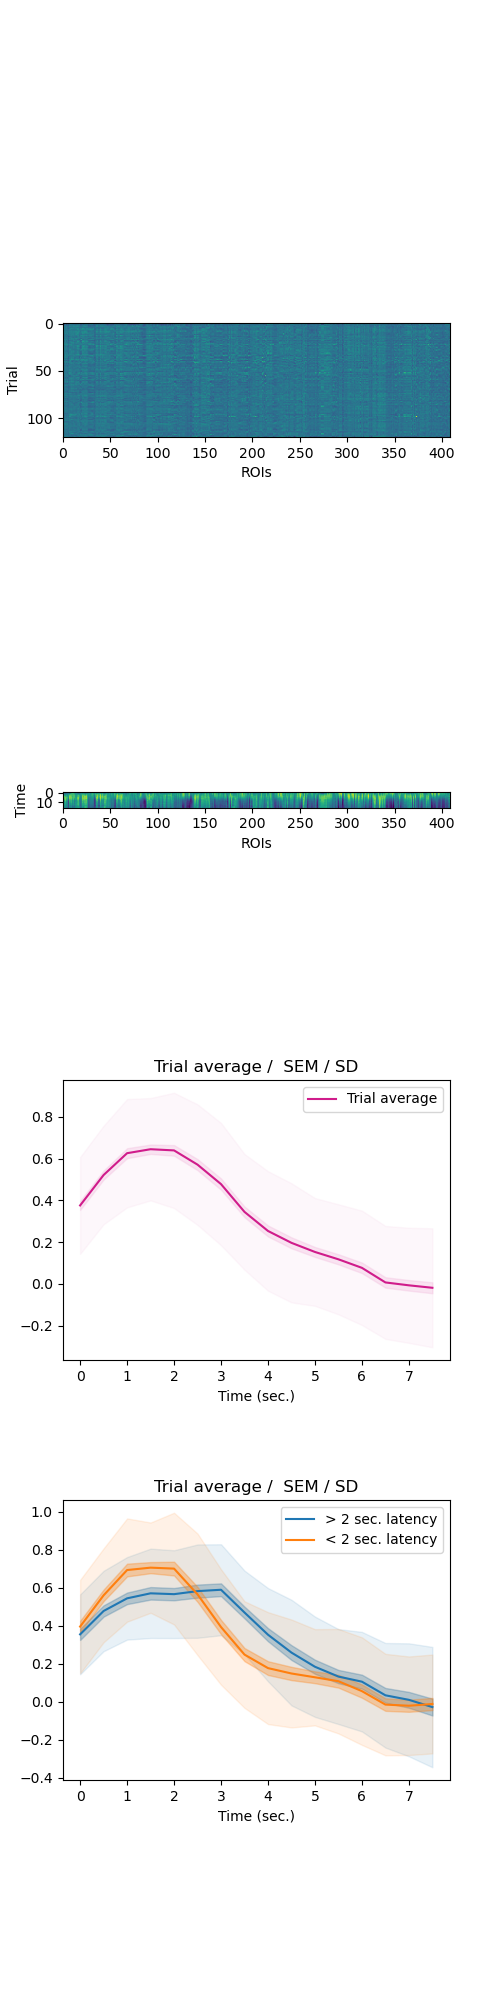

In [34]:
if condition == "stimuli":

    XD = np.squeeze(centers[0,:])
    XD -= np.mean(XD)
    XD /= np.std(XD)
    IND = np.argwhere(np.abs(XD) > 3) 

    #IND = np.argwhere(np.multiply(np.abs(XD) > 3, np.multiply((xx > 450) , (xx < 550))))
    IND = np.argwhere(np.abs(XD) > 3)
    
    
    
    tc_lag = 16
    TTC = np.transpose(TC)
    
    TC2 = np.zeros((len(IND),int(reg_notr), int(reg_dur)))
    for t in range(reg_notr):
         TC2[:,t,:] = np.squeeze(TTC[IND,reg_starts[t]:reg_ends[t]:1])
    
    TC3= np.squeeze(TC2[:,:,:tc_lag])
    

    mean_TC3_A = np.mean(TC3,-1)

    plt.close('all') 
    plt.clf 

    sc_trial_latency2 = sc_trial_latency
    # larger than 6 not considered latency anymore
    sc_trial_latency2[sc_trial_latency > 6] = -1

    
    fig, axes = plt.subplots(
                     ncols=1,
                     nrows=4,
                     figsize=(5, 20))
    
    fig.subplots_adjust(hspace=0.5)

    ax1, ax2, ax3, ax4 = axes.flatten()
    
    ax1.imshow(np.transpose(mean_TC3_A))
    ax1.set_ylabel('Trial')
    ax1.set_xlabel('ROIs')

    #plt.imshow(sc_trial_latency2.T)
    #ax1.savefig('{}/Dyn_roi_vs_trial.png'.format(results_path), format='png')
    #ax1.savefig('{}/Dyn_roi_vs_trial.pdf'.format(results_path), format='pdf')


    mean_TC3_B = np.mean(TC3,1)


    ax2.imshow(np.transpose(mean_TC3_B))
    ax2.set_xlabel('ROIs')
    ax2.set_ylabel('Time')
    #ax2.savefig('{}/Dyn_lag_vs_trial.png'.format(results_path), format='png')
    #ax2.savefig('{}/Dyn_lag_vs_trial.pdf'.format(results_path), format='pdf')

    mean_TC3_C = np.mean(np.mean(TC3,0),0)
    STD_TC3_C = np.std(np.mean(TC3,0),0)
    SEM_TC3_C = sem(np.mean(TC3,0),0)


    lag_x = np.arange(0,tc_lag/2,.5)


    ax3.plot(lag_x,mean_TC3_C,label = 'Trial average', c = '#d01c8b' )
    ax3.set_xlabel('Time (sec.)')

    ax3.fill_between(lag_x,mean_TC3_C-STD_TC3_C, mean_TC3_C+STD_TC3_C,alpha=0.1,color = '#f1b6da')
    ax3.fill_between(lag_x,mean_TC3_C-SEM_TC3_C, mean_TC3_C+SEM_TC3_C,alpha=0.3,color = '#f1b6da')

    #ax3.plot(lag_x,np.transpose(mean_TC3_B[40,:]), label = 'trial example')
    ax3.set_title("Trial average /  SEM / SD")


    #ax3.savefig('{}/Dyn_all.png'.format(results_path), format='png')
    #ax3.savefig('{}/Dyn_all.pdf'.format(results_path), format='pdf')
    ax3.legend()
    

    sc_trial_latency2 = np.concatenate(sc_trial_latency).astype(None)


    IND_LAG1 = np.squeeze(np.argwhere(sc_trial_latency2 > 2))
    IND_LAG2 = np.squeeze(np.argwhere((sc_trial_latency2 <= 2) * (sc_trial_latency2 >= 0)))


    mean_TC3_A1 = np.mean(np.mean(TC3[:,IND_LAG1,:],0),0)
    std_TC3_A1 = np.std(np.mean(TC3[:,IND_LAG1,:],0),0)

    mean_TC3_A2 = np.mean(np.mean(TC3[:,IND_LAG2,:],0),0)
    std_TC3_A2 = np.std(np.mean(TC3[:,IND_LAG2,:],0),0)
    
    sem_TC3_A1 = sem(np.mean(TC3[:,IND_LAG1,:],0),0)

    sem_TC3_A2 = sem(np.mean(TC3[:,IND_LAG2,:],0),0)


    ax4.plot(lag_x,mean_TC3_A1, c = '#1f77b4', label='> 2 sec. latency')
    ax4.fill_between(lag_x,mean_TC3_A1-std_TC3_A1, mean_TC3_A1+std_TC3_A1,alpha=0.1, color =  '#1f77b4')
    ax4.fill_between(lag_x,mean_TC3_A1-sem_TC3_A1, mean_TC3_A1+sem_TC3_A1,alpha=0.3,  color =  '#1f77b4')


    ax4.plot(lag_x,mean_TC3_A2, c = '#ff7f0e',label='< 2 sec. latency')
    ax4.fill_between(lag_x,mean_TC3_A2-std_TC3_A2, mean_TC3_A2+std_TC3_A2,alpha=0.1, color  = '#ff7f0e' )
    ax4.fill_between(lag_x,mean_TC3_A2-sem_TC3_A2, mean_TC3_A2+sem_TC3_A2,alpha=0.3,  color  = '#ff7f0e')


    ax4.set_xlabel('Time (sec.)')
    ax4.legend()
    ax4.set_title("Trial average /  SEM / SD")


    
    
    plt.show()
    #plt.savefig('{}/Dyn_all_around2.png'.format(results_path), format='png')
    #plt.savefig('{}/Dyn_all_around2.pdf'.format(results_path), format='pdf')


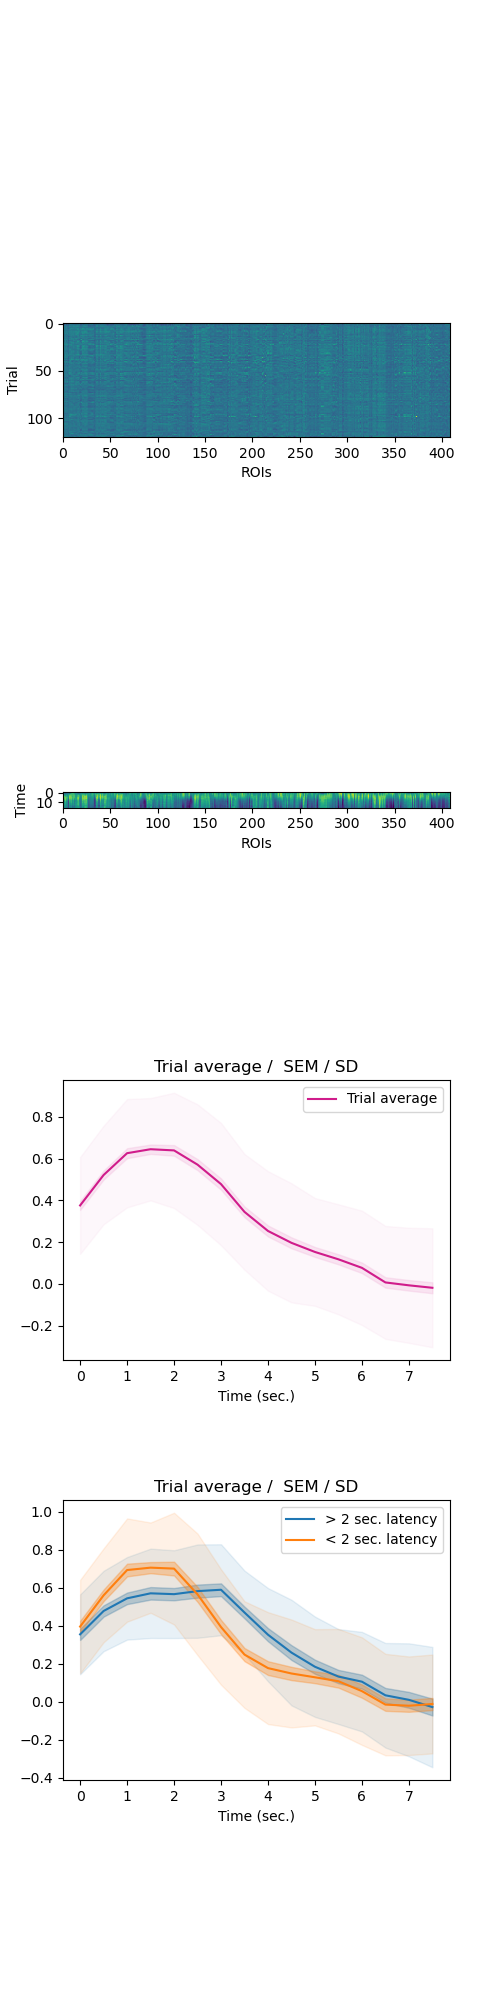

In [35]:
if condition == "rest":

    XD = np.squeeze(centers[0,:])
    XD -= np.mean(XD)
    XD /= np.std(XD)
    IND = np.argwhere(np.abs(XD) > 3) 

    #IND = np.argwhere(np.multiply(np.abs(XD) > 3, (xx > 450) * (xx < 600)))
    IND = np.argwhere(np.abs(XD) > 3)

    
    transition_number_of_bouts = np.empty(notr-1)
    transition_number_of_bouts[:] = 0

    for g in range(notr-1):
        bouts_in_this_transition= np.argwhere(((boutfeat.t_start<gr_ends[g]) & (boutfeat.t_end>=gr_ends[g])).to_numpy())
        if bouts_in_this_transition.size:
            transition_number_of_bouts[g]=len(bouts_in_this_transition)

    plt.close('all') 
    plt.clf 

    ind_tran0 = np.argwhere(transition_number_of_bouts == 0)
    ind_tran1 = np.argwhere(transition_number_of_bouts == 1)

    fig, ax = plt.subplots()
    k=0

    #occ_tran = reg_kk_trial_blocks_duration[k,:]
    occ_tran = occ_trial_first[k,:]
    occ_tran = occ_per_trial[k,:]

    a = {'No bout': np.concatenate(occ_tran[ind_tran0]).astype(None), 'Bout':  np.concatenate(occ_tran[ind_tran1]).astype(None)}
    df_plot = pd.DataFrame.from_dict(a, orient='index')
    df_plot = df_plot.transpose()

    sns.barplot(data =  df_plot ,  color="#4db1a6")
    ax.set_title('Duration of cluster 1')
    ax.set_ylabel('Nb of occ. (duration)')

    plt.show()
    plt.savefig('{}/map_{}_duration_bouts.png'.format(results_path,k+1), format='png')
    plt.savefig('{}/map_{}_duration_bouts.pdf'.format(results_path,k+1), format='pdf')
    
    
    
        
    tc_lag_post = 30
    tc_lag_pre = 5
    tc_lag = tc_lag_pre+tc_lag_post

    
    TTC = np.transpose(TC)
    
    TC2 = np.zeros((len(IND),int(reg_notr), int(reg_dur)+tc_lag_pre))
    for t in range(reg_notr):
         TC2[:,t,:] = np.squeeze(TTC[IND,reg_starts[t]-tc_lag_pre:reg_ends[t]:1])
    
    TC3= np.squeeze(TC2[:,:,:tc_lag])
    

    mean_TC3_A = np.mean(TC3,-1)

    plt.close('all') 
    plt.clf 

    
    
    fig, axes = plt.subplots(
                     ncols=1,
                     nrows=4,
                     figsize=(5, 20))
    
    fig.subplots_adjust(hspace=0.5)

    ax1, ax2, ax3, ax4= axes.flatten()
    
    ax1.imshow(np.transpose(mean_TC3_A))
    ax1.set_ylabel('Trial')
    ax1.set_xlabel('ROIs')

    #plt.imshow(sc_trial_latency2.T)
    #ax1.savefig('{}/Dyn_roi_vs_trial.png'.format(results_path), format='png')
    #ax1.savefig('{}/Dyn_roi_vs_trial.pdf'.format(results_path), format='pdf')


    mean_TC3_B = np.mean(TC3,1)


    ax2.imshow(np.transpose(mean_TC3_B))
    ax2.set_xlabel('ROIs')
    ax2.set_ylabel('Time')
    #ax2.savefig('{}/Dyn_lag_vs_trial.png'.format(results_path), format='png')
    #ax2.savefig('{}/Dyn_lag_vs_trial.pdf'.format(results_path), format='pdf')

    mean_TC3_C = np.mean(np.mean(TC3,0),0)
    STD_TC3_C = np.std(np.mean(TC3,0),0)

    lag_x = np.arange(0,tc_lag/2,.5)


    ax3.plot(lag_x,mean_TC3_C, label = 'trial average ',c = '#d01c8b' )
    ax3.set_xlabel('Time (sec.)')
    ax3.set_ylabel('Resp.')


    ax3.fill_between(lag_x,mean_TC3_C-STD_TC3_C, mean_TC3_C+STD_TC3_C,alpha=0.3 ,color = '#f1b6da')
    ax3.plot(lag_x,np.transpose(mean_TC3_B[20,:]), label = 'trial example')

    #ax3.savefig('{}/Dyn_all.png'.format(results_path), format='png')
    #ax3.savefig('{}/Dyn_all.pdf'.format(results_path), format='pdf')
    ax3.legend()
    

    IND_LAG1 = ind_tran1
    IND_LAG2 = ind_tran0


    mean_TC3_A1 = np.squeeze(np.mean(np.mean(TC3[:,IND_LAG1,:],0),0))
    std_TC3_A1 = np.squeeze(np.std(np.mean(TC3[:,IND_LAG1,:],0),0))

    mean_TC3_A2 = np.squeeze(np.mean(np.mean(TC3[:,IND_LAG2,:],0),0))
    std_TC3_A2 = np.squeeze(np.std(np.mean(TC3[:,IND_LAG2,:],0),0))
    
    
    
    sem_TC3_A1 = np.squeeze(sem(np.mean(TC3[:,IND_LAG1,:],0),0))

    sem_TC3_A2 = np.squeeze(sem(np.mean(TC3[:,IND_LAG2,:],0),0))


    ax4.plot(lag_x,mean_TC3_A1, c = '#1f77b4',label='  Bouts')
    ax4.fill_between(lag_x,mean_TC3_A1-std_TC3_A1, mean_TC3_A1+std_TC3_A1,alpha=0.1 , color = '#1f77b4')
    ax4.fill_between(lag_x,mean_TC3_A1-sem_TC3_A1, mean_TC3_A1+sem_TC3_A1,alpha=0.2 , color = '#1f77b4')


    ax4.plot(lag_x,mean_TC3_A2,  c = '#ff7f0e', label='  No Bouts')
    ax4.fill_between(lag_x,mean_TC3_A2-std_TC3_A2, mean_TC3_A2+std_TC3_A2,alpha=0.1, color = '#ff7f0e')
    ax4.fill_between(lag_x,mean_TC3_A2-sem_TC3_A2, mean_TC3_A2+sem_TC3_A2,alpha=0.2, color = '#ff7f0e')


    ax4.set_xlabel('Time (sec.)')
    ax4.set_ylabel('Resp.')

    ax4.legend()
    ax4.legend(loc = "lower right")
    ax4.set_title(" Trial average / SEM /  SD")
    


    ax4.axvline(x=lag_x[tc_lag_pre-1],  color='k', linestyle='--')
    


plt.show()    

    
    
    
    #plt.savefig('{}/Dyn_all_bouts.png'.format(results_path), format='png')
    #plt.savefig('{}/Dyn_all_bouts.pdf'.format(results_path), format='pdf')
    
    


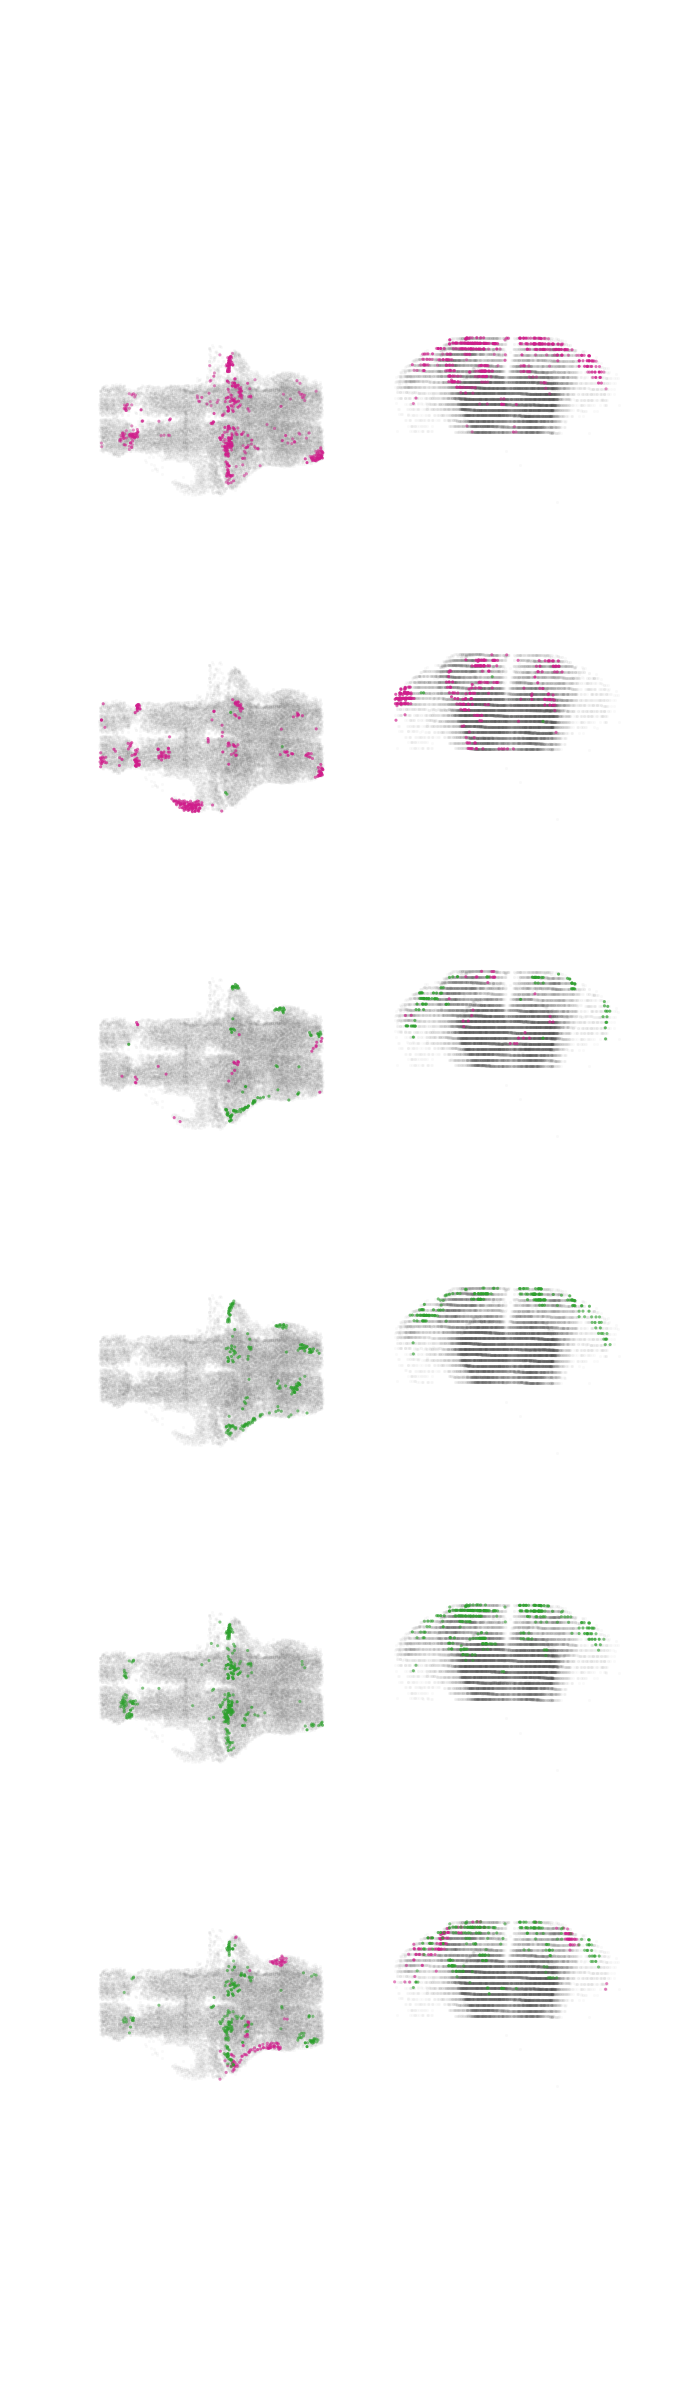

In [36]:

plt.close('all') 
plt.clf 

f, axs = plt.subplots(n_clusters, 2, figsize=(7, 24))


for i in range(n_clusters):


    X0=centers[i,:]
    Xplot = np.squeeze(X0)
    Xplot -= np.mean(Xplot)
    Xplot /= np.std(Xplot)
    Xplot[np.abs(Xplot) < 3] = 0


    mxp = np.ceil(max(np.abs(Xplot)))



    axs[i,0].scatter(
        xx, yy, lw=0, s=5, alpha=0.03, color=(0.3,) * 3,
    )
    axs[i,0].scatter(
        xx, yy, lw=0, s=5, alpha=np.multiply(abs(Xplot/mxp),(Xplot>0)), color='#d01c8b',
    )
    axs[i,0].scatter(
        xx, yy, lw=0, s=5, alpha=np.multiply(abs(Xplot/mxp),(Xplot<0)), color='#2ca02c',
    )
    axs[i,0].axis("equal")
    axs[i,0].axis("off")


    axs[i,1].scatter(
        yy, -zz, lw=0, s=5, alpha=0.03, color=(0.3,) * 3,
    )

    axs[i,1].scatter(
        yy, -zz, lw=0, s=5, alpha=np.multiply(abs(Xplot/mxp),(Xplot>0)), color='#d01c8b',
    )
    axs[i,1].scatter(
        yy, -zz, lw=0, s=5, alpha=np.multiply(abs(Xplot/mxp),(Xplot<0)), color='#2ca02c',
    )
    axs[i,1].axis("equal")
    axs[i,1].axis("off")

    
plt.show()    
#plt.savefig('{}/Clusters_anat.png'.format(results_path), format='png')
#plt.savefig('{}/Clusters_anat.pdf'.format(results_path), format='pdf')

In [37]:
# XD = np.squeeze(centers[0,:])
# XD -= np.mean(XD)
# XD /= np.std(XD)

# IND = np.argwhere(np.multiply(np.abs(XD) > 3,xx > 400)) 
# #IND = np.argwhere(np.abs(XD) > 3) 

# TC_ROI = np.mean(TC[:,IND], axis =1)

# seed_to_rois_correlations = (np.dot(TC.T, TC_ROI) /TC_ROI.shape[0])

# f, axs = plt.subplots(1, 2, figsize=(7, 3))
# axs[0].scatter(
#     xx, yy, lw=0, s=10, alpha=0.2, c = seed_to_rois_correlations,  cmap= my_cmap3
# )
# a1=axs[1].scatter(
#    yy, -zz, lw=0, s=10, alpha=0.2, c = seed_to_rois_correlations,  cmap=my_cmap3
# )

# for i in range(2):
#     # axs[i].set_title(k)
#     axs[i].axis("equal")
#     axs[i].axis("off")
    
# plt.colorbar(a1)

# f, axs = plt.subplots(1, 2, figsize=(7, 3))


# axs[0].scatter(xx, yy, lw=0, s=5, alpha=0.03, color=(0.3,) * 3)

# axs[0].scatter(xx[IND], yy[IND], lw=0, s=5, alpha=0.2, c = 'r')

# axs[1].scatter(yy, -zz, lw=0, s=5, alpha=0.03, color=(0.3,) * 3)
    
# axs[1].scatter(yy[IND], -zz[IND], lw=0, s=5, alpha=0.2,  c = 'r')


# for i in range(2):
#     # axs[i].set_title(k)
#     axs[i].axis("equal")
#     axs[i].axis("off")
    

# #plt.show()    
# #plt.savefig('{}/Clusters_anat.png'.format(results_path), format='png')
# #plt.savefig('{}/Clusters_anat.pdf'.format(results_path), format='pdf')


In [38]:
XD = np.squeeze(centers[0,:])
XD -= np.mean(XD)
XD /= np.std(XD)

IND1 = np.argwhere(np.multiply(np.abs(XD) > 3,xx < fbmax)) 
IND2 = np.argwhere(np.multiply(np.abs(XD) > 3, (xx > hbmin) * (xx < hbmax) * (zz <hbmax_z))) 

#IND = np.argwhere(np.abs(XD) > 3) 

TC_ROI1 = np.mean(TC[:,IND1], axis =1)
TC_ROI2 = np.mean(TC[:,IND2], axis =1)

In [39]:
TC_ROI_trial1 = np.zeros((int(2*gr_starts[1] - 2*gr_starts[0] - 1),len(gr_starts)-1))
TC_ROI_trial2 = np.zeros((int(2*gr_starts[1] - 2*gr_starts[0] - 1),len(gr_starts)-1))


for i in range(len(gr_starts)-1):
    TC_ROI_trial1[:,i] = np.squeeze(TC_ROI1[int(2*gr_starts[i]):int(2*gr_starts[i+1])-1:1])
    TC_ROI_trial2[:,i] = np.squeeze(TC_ROI2[int(2*gr_starts[i]):int(2*gr_starts[i+1])-1:1])

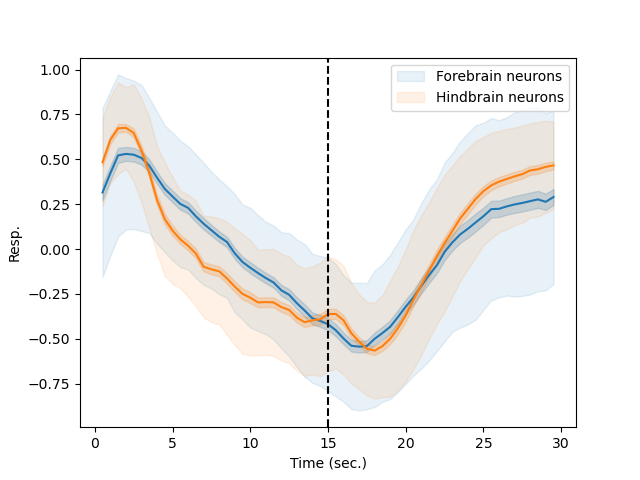

In [40]:
mean_TC_ROI_trial1 = np.mean(TC_ROI_trial1,1)
mean_TC_ROI_trial2 = np.mean(TC_ROI_trial2,1)

std_TC_ROI_trial1 = np.std(TC_ROI_trial1,1)
std_TC_ROI_trial2 = np.std(TC_ROI_trial2,1)

sem_TC_ROI_trial1 = sem(TC_ROI_trial1,1)
sem_TC_ROI_trial2 = sem(TC_ROI_trial2,1)


plt.close('all') 
plt.clf 


tim_x = np.arange(0.5,30,.5)


plt.plot(tim_x,mean_TC_ROI_trial1,'C0')
plt.fill_between(tim_x,mean_TC_ROI_trial1-std_TC_ROI_trial1, mean_TC_ROI_trial1+std_TC_ROI_trial1,alpha=0.1, label='Forebrain neurons',color = 'C0')
plt.fill_between(tim_x,mean_TC_ROI_trial1-sem_TC_ROI_trial1, mean_TC_ROI_trial1+sem_TC_ROI_trial1,alpha=0.2,color = 'C0')

plt.plot(tim_x,mean_TC_ROI_trial2,'C1')
plt.fill_between(tim_x,mean_TC_ROI_trial2-std_TC_ROI_trial2, mean_TC_ROI_trial2+std_TC_ROI_trial2,alpha=0.1, label='Hindbrain neurons',color = 'C1')
plt.fill_between(tim_x,mean_TC_ROI_trial2-sem_TC_ROI_trial2, mean_TC_ROI_trial2+sem_TC_ROI_trial2,alpha=0.2,color = 'C1')

plt.legend()

plt.xlabel('Time (sec.)')
plt.ylabel('Resp.')


    
plt.axvline(x=tim_x[29],  color='k', linestyle='--')

    
plt.show()    
#plt.savefig('{}/HBvsFB.png'.format(results_path), format='png')
#plt.savefig('{}/HBvsFB.pdf'.format(results_path), format='pdf')

In [41]:
if condition == "rest":


    mean_TC_ROI_trial1_bout = np.squeeze(np.mean(TC_ROI_trial1[:,IND_LAG1],1))
    mean_TC_ROI_trial2_bout = np.squeeze(np.mean(TC_ROI_trial2[:,IND_LAG1],1))

    std_TC_ROI_trial1_bout = np.squeeze(np.std(TC_ROI_trial1[:,IND_LAG1],1))
    std_TC_ROI_trial2_bout = np.squeeze(np.std(TC_ROI_trial2[:,IND_LAG1],1))

    sem_TC_ROI_trial1_bout = np.squeeze(sem(TC_ROI_trial1[:,IND_LAG1],1))
    sem_TC_ROI_trial2_bout = np.squeeze(sem(TC_ROI_trial2[:,IND_LAG1],1))

    mean_TC_ROI_trial1_nobout = np.squeeze(np.mean(TC_ROI_trial1[:,IND_LAG2],1))
    mean_TC_ROI_trial2_nobout = np.squeeze(np.mean(TC_ROI_trial2[:,IND_LAG2],1))

    std_TC_ROI_trial1_nobout = np.squeeze(np.std(TC_ROI_trial1[:,IND_LAG2],1))
    std_TC_ROI_trial2_nobout = np.squeeze(np.std(TC_ROI_trial2[:,IND_LAG2],1))

    sem_TC_ROI_trial1_nobout = np.squeeze(sem(TC_ROI_trial1[:,IND_LAG2],1))
    sem_TC_ROI_trial2_nobout = np.squeeze(sem(TC_ROI_trial2[:,IND_LAG2],1))





    plt.close('all') 
    plt.clf 

    f, axs = plt.subplots(1, 2, figsize=(14, 6))


    tim_x = np.arange(0.5,30,.5)


    axs[0].plot(tim_x,mean_TC_ROI_trial1_bout,'C0')
    axs[0].fill_between(tim_x,mean_TC_ROI_trial1_bout-std_TC_ROI_trial1_bout, mean_TC_ROI_trial1_bout+std_TC_ROI_trial1_bout,alpha=0.1, label='Bout',color = 'C0')
    axs[0].fill_between(tim_x,mean_TC_ROI_trial1_bout-sem_TC_ROI_trial1_bout, mean_TC_ROI_trial1_bout+sem_TC_ROI_trial1_bout,alpha=0.2,color = 'C0')


    axs[0].plot(tim_x,mean_TC_ROI_trial1_nobout,'C1')
    axs[0].fill_between(tim_x,mean_TC_ROI_trial1_nobout-std_TC_ROI_trial1_nobout, mean_TC_ROI_trial1_nobout+std_TC_ROI_trial1_nobout,alpha=0.1, label='No Bout',color = 'C1')
    axs[0].fill_between(tim_x,mean_TC_ROI_trial1_nobout-sem_TC_ROI_trial1_nobout, mean_TC_ROI_trial1_nobout+sem_TC_ROI_trial1_nobout,alpha=0.2,color = 'C1')

    axs[0].legend()

    axs[0].set_xlabel('Time (sec.)')
    axs[0].set_ylabel('Resp.')
    axs[0].set_title('Forebrain Neurons.')




    axs[0].axvline(x=tim_x[29],  color='k', linestyle='--')



    axs[1].plot(tim_x,mean_TC_ROI_trial2_bout,'C0')
    axs[1].fill_between(tim_x,mean_TC_ROI_trial2_bout-std_TC_ROI_trial2_bout, mean_TC_ROI_trial2_bout+std_TC_ROI_trial2_bout,alpha=0.1, label='Bout',color = 'C0')
    axs[1].fill_between(tim_x,mean_TC_ROI_trial2_bout-sem_TC_ROI_trial2_bout, mean_TC_ROI_trial2_bout+sem_TC_ROI_trial2_bout,alpha=0.2,color = 'C0')

    axs[1].plot(tim_x,mean_TC_ROI_trial2_nobout,'C1')
    axs[1].fill_between(tim_x,mean_TC_ROI_trial2_nobout-std_TC_ROI_trial2_nobout, mean_TC_ROI_trial2_nobout+std_TC_ROI_trial2_bout,alpha=0.1, label='No bout',color = 'C1')
    axs[1].fill_between(tim_x,mean_TC_ROI_trial2_nobout-sem_TC_ROI_trial2_nobout, mean_TC_ROI_trial2_nobout+sem_TC_ROI_trial2_bout,alpha=0.2,color = 'C1')

    axs[1].legend()

    axs[1].set_xlabel('Time (sec.)')
    axs[1].set_ylabel('Resp.')
    axs[1].set_title('Hindbrain Neurons.')




    axs[1].axvline(x=tim_x[29],  color='k', linestyle='--')

    plt.show()    
    #plt.savefig('{}/HBvsFB_boutCond.png'.format(results_path), format='png')
    #plt.savefig('{}/HBvsFB_boutCond.pdf'.format(results_path), format='pdf')

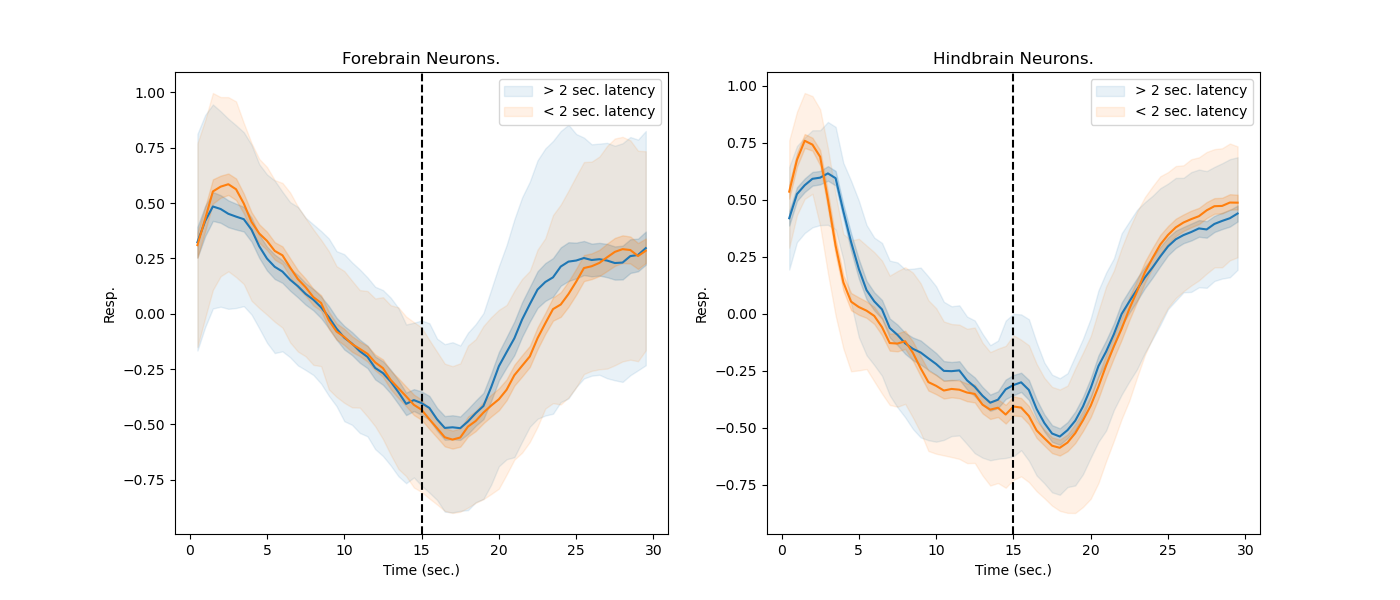

In [42]:
if condition == "stimuli":


    IND_LAG1 = IND_LAG1[~(IND_LAG1 == notr-1)]
    IND_LAG2 = IND_LAG2[~(IND_LAG2 == notr-1)]

    mean_TC_ROI_trial1_bout = np.squeeze(np.mean(TC_ROI_trial1[:,IND_LAG1],1))
    mean_TC_ROI_trial2_bout = np.squeeze(np.mean(TC_ROI_trial2[:,IND_LAG1],1))

    std_TC_ROI_trial1_bout = np.squeeze(np.std(TC_ROI_trial1[:,IND_LAG1],1))
    std_TC_ROI_trial2_bout = np.squeeze(np.std(TC_ROI_trial2[:,IND_LAG1],1))

    sem_TC_ROI_trial1_bout = np.squeeze(sem(TC_ROI_trial1[:,IND_LAG1],1))
    sem_TC_ROI_trial2_bout = np.squeeze(sem(TC_ROI_trial2[:,IND_LAG1],1))

    mean_TC_ROI_trial1_nobout = np.squeeze(np.mean(TC_ROI_trial1[:,IND_LAG2],1))
    mean_TC_ROI_trial2_nobout = np.squeeze(np.mean(TC_ROI_trial2[:,IND_LAG2],1))

    std_TC_ROI_trial1_nobout = np.squeeze(np.std(TC_ROI_trial1[:,IND_LAG2],1))
    std_TC_ROI_trial2_nobout = np.squeeze(np.std(TC_ROI_trial2[:,IND_LAG2],1))

    sem_TC_ROI_trial1_nobout = np.squeeze(sem(TC_ROI_trial1[:,IND_LAG2],1))
    sem_TC_ROI_trial2_nobout = np.squeeze(sem(TC_ROI_trial2[:,IND_LAG2],1))





    plt.close('all') 
    plt.clf 

    f, axs = plt.subplots(1, 2, figsize=(14, 6))


    tim_x = np.arange(0.5,30,.5)


    axs[0].plot(tim_x,mean_TC_ROI_trial1_bout,'C0')
    axs[0].fill_between(tim_x,mean_TC_ROI_trial1_bout-std_TC_ROI_trial1_bout, mean_TC_ROI_trial1_bout+std_TC_ROI_trial1_bout,alpha=0.1, label='> 2 sec. latency',color = 'C0')
    axs[0].fill_between(tim_x,mean_TC_ROI_trial1_bout-sem_TC_ROI_trial1_bout, mean_TC_ROI_trial1_bout+sem_TC_ROI_trial1_bout,alpha=0.2,color = 'C0')


    axs[0].plot(tim_x,mean_TC_ROI_trial1_nobout,'C1')
    axs[0].fill_between(tim_x,mean_TC_ROI_trial1_nobout-std_TC_ROI_trial1_nobout, mean_TC_ROI_trial1_nobout+std_TC_ROI_trial1_nobout,alpha=0.1, label='< 2 sec. latency',color = 'C1')
    axs[0].fill_between(tim_x,mean_TC_ROI_trial1_nobout-sem_TC_ROI_trial1_nobout, mean_TC_ROI_trial1_nobout+sem_TC_ROI_trial1_nobout,alpha=0.2,color = 'C1')

    axs[0].legend()

    axs[0].set_xlabel('Time (sec.)')
    axs[0].set_ylabel('Resp.')
    axs[0].set_title('Forebrain Neurons.')




    axs[0].axvline(x=tim_x[29],  color='k', linestyle='--')



    axs[1].plot(tim_x,mean_TC_ROI_trial2_bout,'C0')
    axs[1].fill_between(tim_x,mean_TC_ROI_trial2_bout-std_TC_ROI_trial2_bout, mean_TC_ROI_trial2_bout+std_TC_ROI_trial2_bout,alpha=0.1, label='> 2 sec. latency',color = 'C0')
    axs[1].fill_between(tim_x,mean_TC_ROI_trial2_bout-sem_TC_ROI_trial2_bout, mean_TC_ROI_trial2_bout+sem_TC_ROI_trial2_bout,alpha=0.2,color = 'C0')

    axs[1].plot(tim_x,mean_TC_ROI_trial2_nobout,'C1')
    axs[1].fill_between(tim_x,mean_TC_ROI_trial2_nobout-std_TC_ROI_trial2_nobout, mean_TC_ROI_trial2_nobout+std_TC_ROI_trial2_bout,alpha=0.1, label='< 2 sec. latency',color = 'C1')
    axs[1].fill_between(tim_x,mean_TC_ROI_trial2_nobout-sem_TC_ROI_trial2_nobout, mean_TC_ROI_trial2_nobout+sem_TC_ROI_trial2_bout,alpha=0.2,color = 'C1')

    axs[1].legend()

    axs[1].set_xlabel('Time (sec.)')
    axs[1].set_ylabel('Resp.')
    axs[1].set_title('Hindbrain Neurons.')




    axs[1].axvline(x=tim_x[29],  color='k', linestyle='--')

    plt.show()    
    #plt.savefig('{}/HBvsFB_boutCond.png'.format(results_path), format='png')
    #plt.savefig('{}/HBvsFB_boutCond.pdf'.format(results_path), format='pdf')

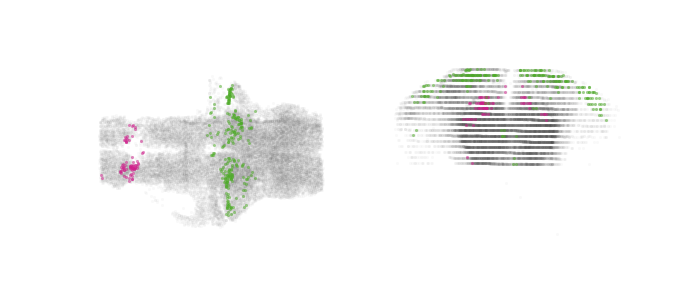

In [43]:

f, axs = plt.subplots(1, 2, figsize=(7, 3))


axs[0].scatter(xx, yy, lw=0, s=5, alpha=0.03, color=(0.3,) * 3)

axs[0].scatter(xx[IND1], yy[IND1], lw=0, s=5, alpha=0.5, color = '#d01c8b')

axs[0].scatter(xx[IND2], yy[IND2], lw=0, s=5, alpha=0.5, color = '#4dac26')


axs[1].scatter(yy, -zz, lw=0, s=5, alpha=0.03, color=(0.3,) * 3)
    
axs[1].scatter(yy[IND1], -zz[IND1], lw=0, s=5, alpha=0.5,  color = '#d01c8b')

axs[1].scatter(yy[IND2], -zz[IND2], lw=0, s=5, alpha=0.5,  color = '#4dac26')



for i in range(2):
    # axs[i].set_title(k)
    axs[i].axis("equal")
    axs[i].axis("off")
    
plt.show()    
#plt.savefig('{}/HBvsFB_mask.png'.format(results_path), format='png')
#plt.savefig('{}/HBvsFB_mask.pdf'.format(results_path), format='pdf')
    